In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.jla_supernovae.jla_simulator as jla
import ndes.ndes as ndes
import delfi.delfi as delfi
import compression.score.score as score
import distributions.priors as priors
import tensorflow as tf
%matplotlib inline

In [2]:
### SET UP FOR SIMULATION CODE ###

JLASimulator = jla.JLA_Model()

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args):
    
    return JLASimulator.simulation(theta, seed)
simulator_args = None

/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_JUSTIN/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [3]:
### SET UP THE PRIOR ###

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior_covariance = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
prior_covariance[0,1] = prior_covariance[1,0] = -0.8*0.4*0.75
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Expected data (mean) and covariance
mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Gaussian(theta_fiducial, mu, Cinv, dmudt, prior_mean = prior_mean, prior_covariance = prior_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [5]:
### LOAD IN THE DATA VECTOR ###
data = compressor(JLASimulator.data, compressor_args)

In [12]:
# Create the neural density estimator (MAF)
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=6, n_outputs=6, n_hiddens=[50,50], 
                                               n_mades=5, act_fun=tf.tanh)

# Create the DELFI object
Delfi = delfi.Delfi(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                       results_dir = "simulators/jla_supernovae/results/maf")

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 8.9310, Val_loss: 8.9466
Epoch 00001, Train_loss: 7.9585, Val_loss: 8.0011
Epoch 00002, Train_loss: 7.4807, Val_loss: 7.5451
Epoch 00003, Train_loss: 7.1567, Val_loss: 7.2382
Epoch 00004, Train_loss: 6.9755, Val_loss: 7.0362
Epoch 00005, Train_loss: 6.9409, Val_loss: 7.0015
Epoch 00006, Train_loss: 6.8456, Val_loss: 6.9073
Epoch 00007, Train_loss: 6.7624, Val_loss: 6.8311
Epoch 00008, Train_loss: 6.8423, Val_loss: 6.9219
Epoch 00009, Train_loss: 6.7333, Val_loss: 6.8121
Epoch 00010, Train_loss: 6.7491, Val_loss: 6.8334
Epoch 00011, Train_loss: 6.7268, Val_loss: 6.8012
Epoch 00012, Train_loss: 6.6853, Val_loss: 6.7585
Epoch 00013, Train_loss: 6.6778, Val_loss: 6.7570
Epoch 00014, Train_loss: 6.6749, Val_loss: 6.7461
Epoch 00015, Train_loss: 6.7097, Val_loss: 6.7924
Epoch 00016, Train_loss: 6.6512, Val_loss: 6.7412
Epoch 00017, Train_loss: 6.6667, Val_loss: 6.7545
Epoch 00018, Train_l

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Done.
Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Saving simulators/jla_supernovae/results/maffisher_pretrain_post.pdf


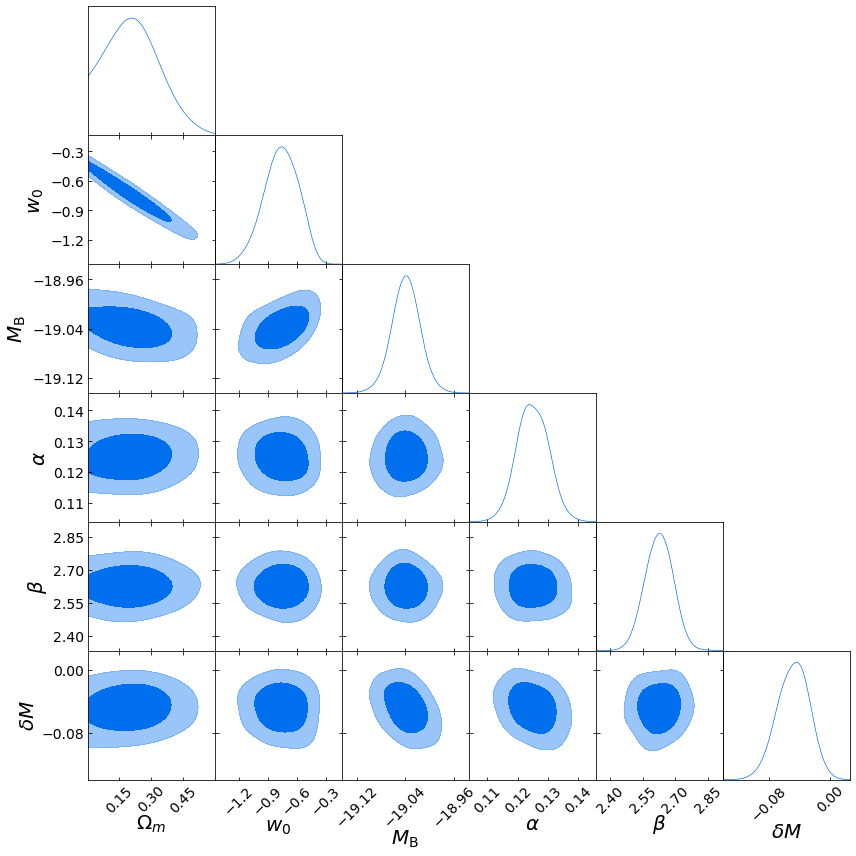

In [13]:
# Do the Fisher pre-training
Delfi.fisher_pretraining(50000, prior, epochs=100, patience=20)

Running initial 500 sims...
Done.
Epoch 00000, Train_loss: 7.2870, Val_loss: 7.4500
Epoch 00001, Train_loss: 6.8599, Val_loss: 7.1485
Epoch 00002, Train_loss: 6.7209, Val_loss: 7.1256
Epoch 00003, Train_loss: 6.6178, Val_loss: 7.1471
Epoch 00004, Train_loss: 6.5123, Val_loss: 7.0366
Epoch 00005, Train_loss: 6.4296, Val_loss: 7.0299
Epoch 00006, Train_loss: 6.3542, Val_loss: 7.0381
Epoch 00007, Train_loss: 6.2868, Val_loss: 7.0219
Epoch 00008, Train_loss: 6.2203, Val_loss: 6.9545
Epoch 00009, Train_loss: 6.1438, Val_loss: 6.9870
Epoch 00010, Train_loss: 6.0823, Val_loss: 6.9783
Epoch 00011, Train_loss: 6.0130, Val_loss: 6.9778
Epoch 00012, Train_loss: 5.9445, Val_loss: 6.9510
Epoch 00013, Train_loss: 5.8853, Val_loss: 6.9619
Epoch 00014, Train_loss: 5.8291, Val_loss: 6.9531
Epoch 00015, Train_loss: 5.8048, Val_loss: 6.9355
Epoch 00016, Train_loss: 5.7403, Val_loss: 6.9370
Epoch 00017, Train_loss: 5.6804, Val_loss: 6.9378
Epoch 00018, Train_loss: 5.6499, Val_loss: 6.9761
Epoch 00019, Tra

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_0.pdf


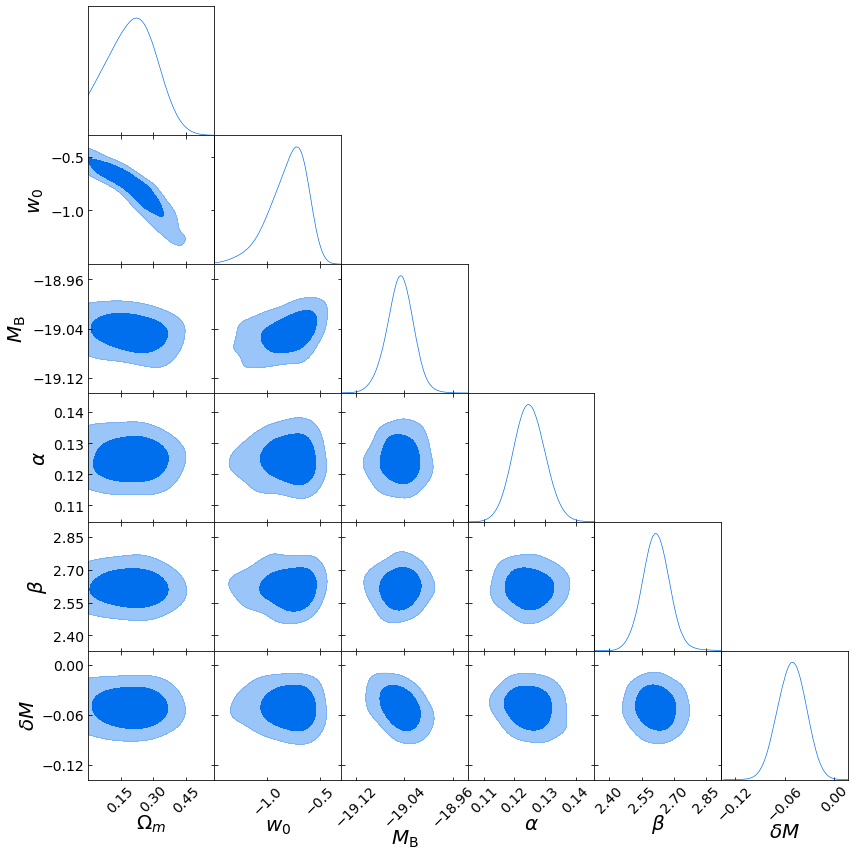

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2355, Val_loss: 6.3572
Epoch 00001, Train_loss: 6.1638, Val_loss: 6.3662
Epoch 00002, Train_loss: 6.1217, Val_loss: 6.3596
Epoch 00003, Train_loss: 6.0987, Val_loss: 6.4114
Epoch 00004, Train_loss: 6.0647, Val_loss: 6.3670
Epoch 00005, Train_loss: 6.0422, Val_loss: 6.3566
Epoch 00006, Train_loss: 6.0263, Val_loss: 6.4026
Epoch 00007, Train_loss: 6.0051, Val_loss: 6.3835
Epoch 00008, Train_loss: 5.9944, Val_loss: 6.3923
Epoch 00009, Train_loss: 5.9747, Val_loss: 6.3838
Epoch 00010, Train_loss: 5.9602, Val_loss: 6.4127
Epoch 00011, Train_loss: 5.9547, Val_loss: 6.4074
Epoch 00012, Train_loss: 5.9310, Val_loss: 6.4142
Epoch 00013, Train_loss: 5.9537, Val_loss: 6.4748
Epoch 00014, Train_loss: 5.9015, Val_loss: 6.4256
Epoch 00015, Train_loss: 5.8930, Val_loss: 6.4835
Epoch 00016, Train_loss: 5.8763, Val_loss: 6.4305
Epoch 00017, Train_loss: 5.8661, Val_loss: 6.4554
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_1.pdf


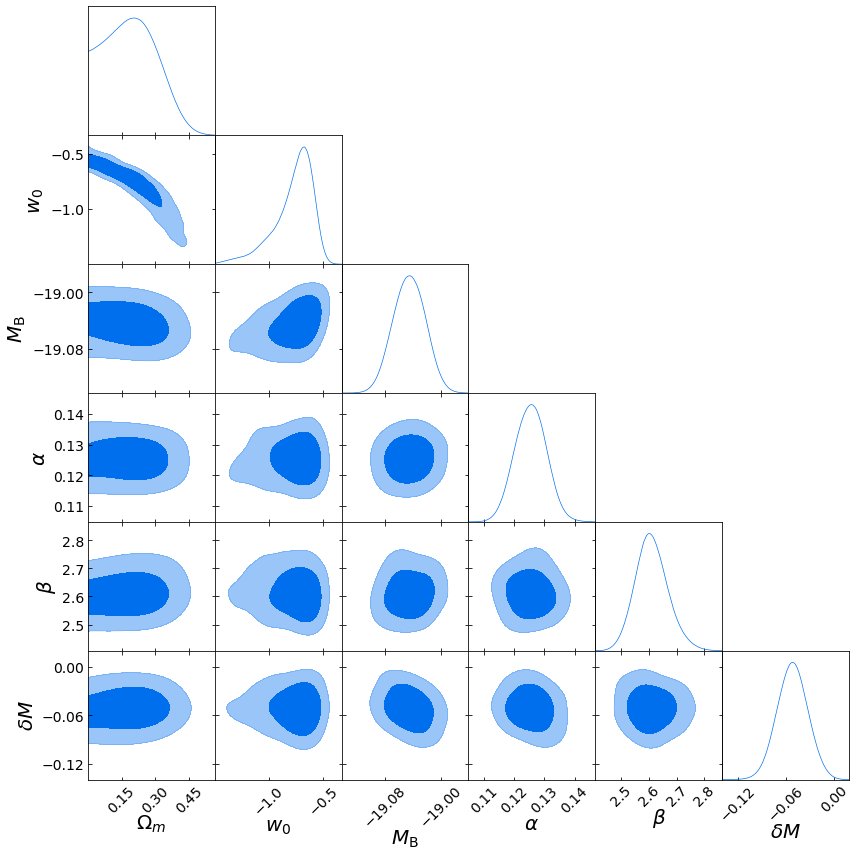

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


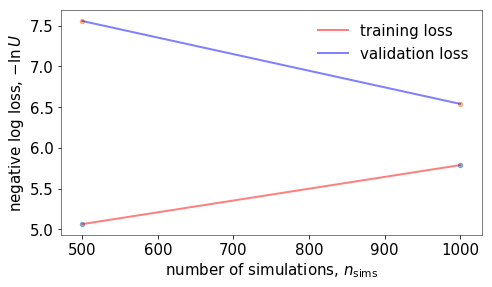

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2479, Val_loss: 6.4378
Epoch 00001, Train_loss: 6.2231, Val_loss: 6.4561
Epoch 00002, Train_loss: 6.2027, Val_loss: 6.4451
Epoch 00003, Train_loss: 6.1899, Val_loss: 6.4251
Epoch 00004, Train_loss: 6.1835, Val_loss: 6.4493
Epoch 00005, Train_loss: 6.1699, Val_loss: 6.4359
Epoch 00006, Train_loss: 6.1595, Val_loss: 6.4547
Epoch 00007, Train_loss: 6.1488, Val_loss: 6.4420
Epoch 00008, Train_loss: 6.1424, Val_loss: 6.4545
Epoch 00009, Train_loss: 6.1326, Val_loss: 6.4442
Epoch 00010, Train_loss: 6.1394, Val_loss: 6.4953
Epoch 00011, Train_loss: 6.1150, Val_loss: 6.4589
Epoch 00012, Train_loss: 6.1257, Val_loss: 6.4547
Epoch 00013, Train_loss: 6.1016, Val_loss: 6.4639
Epoch 00014, Train_loss: 6.0925, Val_loss: 6.4662
Epoch 00015, Train_loss: 6.0861, Val_loss: 6.4574
Epoch 00016, Train_loss: 6.0810, Val_loss: 6.4695
Epoch 00017, Train_loss: 6.0756, Val_loss: 6.4815
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_2.pdf


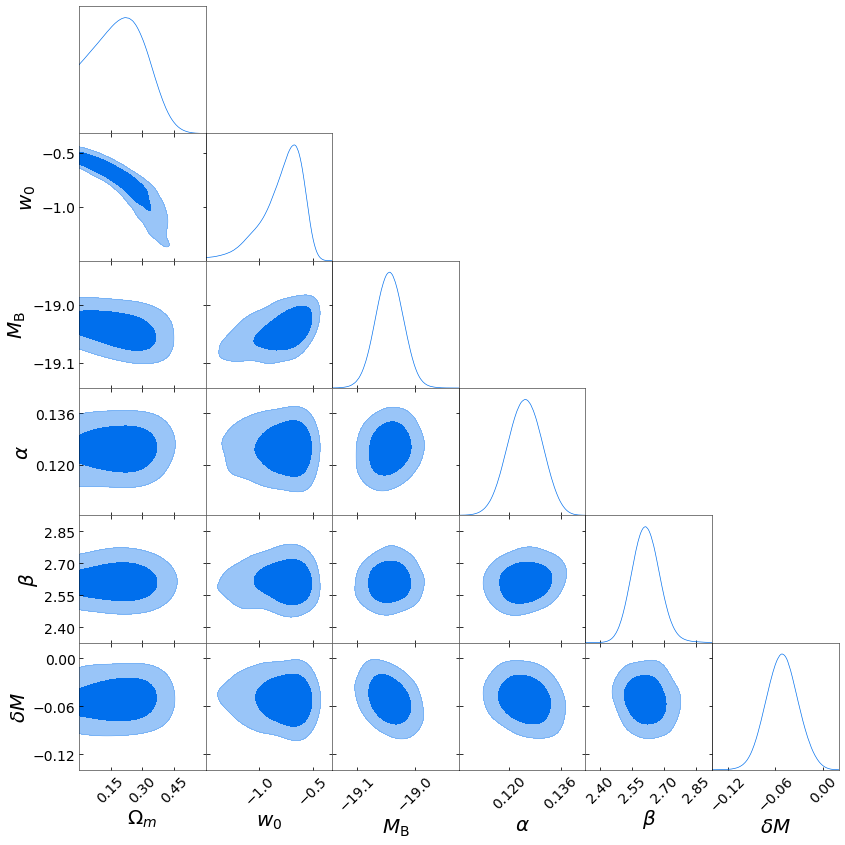

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


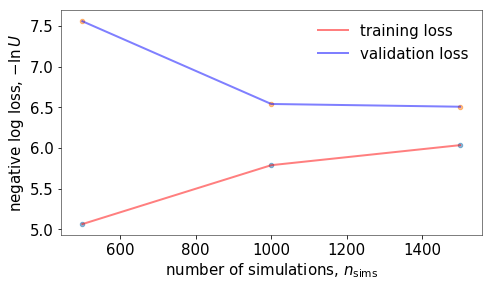

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2554, Val_loss: 6.1243
Epoch 00001, Train_loss: 6.2372, Val_loss: 6.1270
Epoch 00002, Train_loss: 6.2265, Val_loss: 6.1301
Epoch 00003, Train_loss: 6.2140, Val_loss: 6.1187
Epoch 00004, Train_loss: 6.2011, Val_loss: 6.1251
Epoch 00005, Train_loss: 6.1936, Val_loss: 6.1215
Epoch 00006, Train_loss: 6.1828, Val_loss: 6.1299
Epoch 00007, Train_loss: 6.1759, Val_loss: 6.1295
Epoch 00008, Train_loss: 6.1747, Val_loss: 6.1365
Epoch 00009, Train_loss: 6.1646, Val_loss: 6.1498
Epoch 00010, Train_loss: 6.1638, Val_loss: 6.1437
Epoch 00011, Train_loss: 6.1464, Val_loss: 6.1449
Epoch 00012, Train_loss: 6.1462, Val_loss: 6.1456
Epoch 00013, Train_loss: 6.1418, Val_loss: 6.1712
Epoch 00014, Train_loss: 6.1304, Val_loss: 6.1422
Epoch 00015, Train_loss: 6.1325, Val_loss: 6.1767
Epoch 00016, Train_loss: 6.1211, Val_loss: 6.1500
Epoch 00017, Train_loss: 6.1224, Val_loss: 6.1787
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_3.pdf


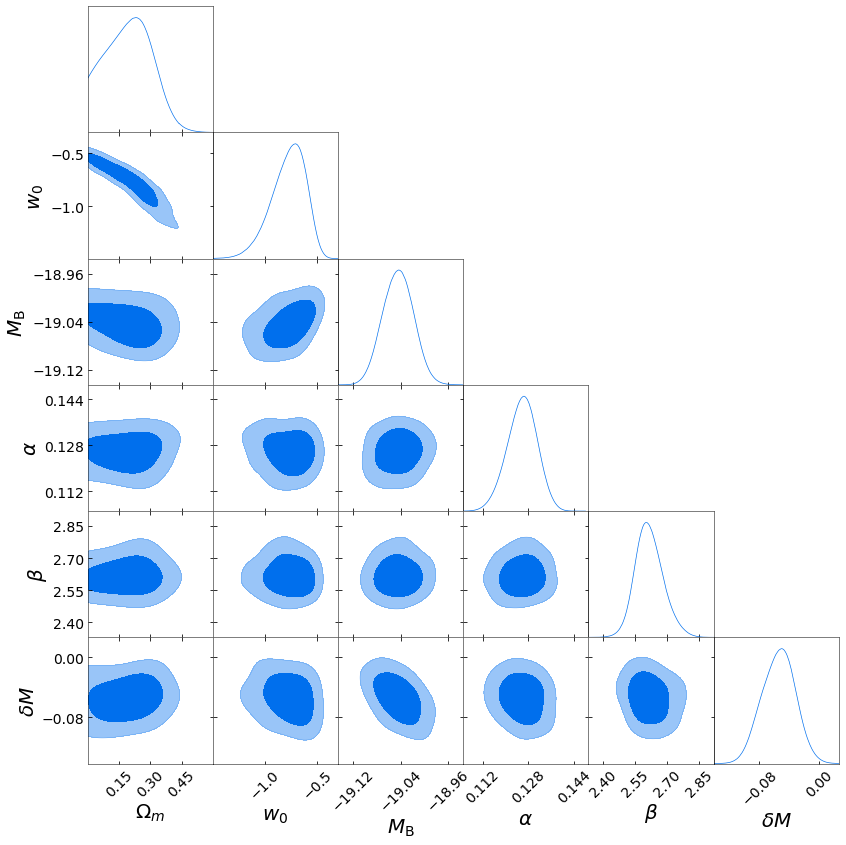

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


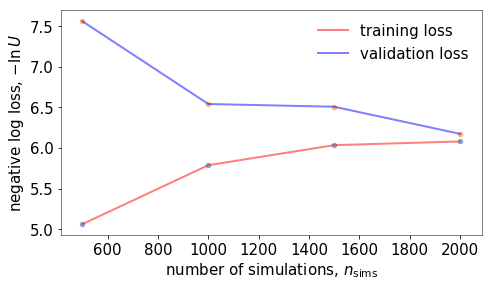

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2539, Val_loss: 6.3787
Epoch 00001, Train_loss: 6.2414, Val_loss: 6.3919
Epoch 00002, Train_loss: 6.2289, Val_loss: 6.3884
Epoch 00003, Train_loss: 6.2259, Val_loss: 6.4056
Epoch 00004, Train_loss: 6.2182, Val_loss: 6.3942
Epoch 00005, Train_loss: 6.2064, Val_loss: 6.3961
Epoch 00006, Train_loss: 6.2057, Val_loss: 6.4172
Epoch 00007, Train_loss: 6.1935, Val_loss: 6.4075
Epoch 00008, Train_loss: 6.1876, Val_loss: 6.3982
Epoch 00009, Train_loss: 6.1799, Val_loss: 6.4086
Epoch 00010, Train_loss: 6.1760, Val_loss: 6.4062
Epoch 00011, Train_loss: 6.1731, Val_loss: 6.4099
Epoch 00012, Train_loss: 6.1677, Val_loss: 6.4182
Epoch 00013, Train_loss: 6.1617, Val_loss: 6.4149
Epoch 00014, Train_loss: 6.1536, Val_loss: 6.4136
Epoch 00015, Train_loss: 6.1512, Val_loss: 6.4138
Epoch 00016, Train_loss: 6.1448, Val_loss: 6.4228
Epoch 00017, Train_loss: 6.1455, Val_loss: 6.4313
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_4.pdf


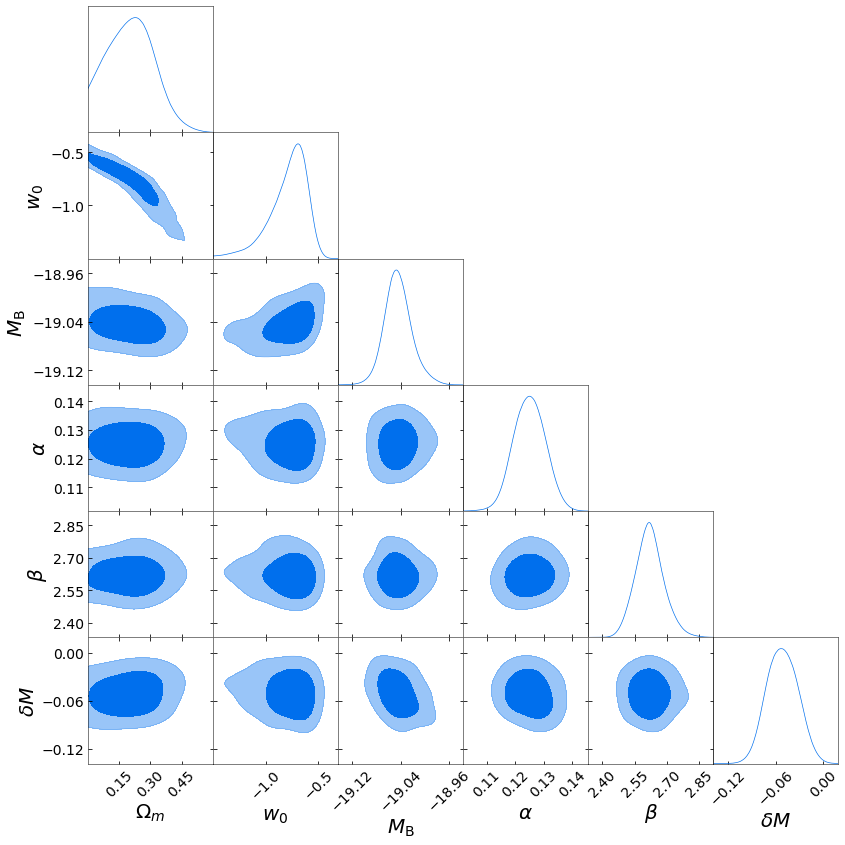

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


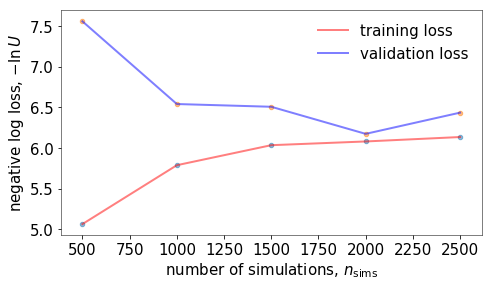

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2758, Val_loss: 6.3261
Epoch 00001, Train_loss: 6.2622, Val_loss: 6.3101
Epoch 00002, Train_loss: 6.2490, Val_loss: 6.3097
Epoch 00003, Train_loss: 6.2461, Val_loss: 6.3434
Epoch 00004, Train_loss: 6.2334, Val_loss: 6.3204
Epoch 00005, Train_loss: 6.2304, Val_loss: 6.3259
Epoch 00006, Train_loss: 6.2210, Val_loss: 6.3339
Epoch 00007, Train_loss: 6.2143, Val_loss: 6.3392
Epoch 00008, Train_loss: 6.2105, Val_loss: 6.3332
Epoch 00009, Train_loss: 6.2122, Val_loss: 6.3674
Epoch 00010, Train_loss: 6.1984, Val_loss: 6.3407
Epoch 00011, Train_loss: 6.1982, Val_loss: 6.3388
Epoch 00012, Train_loss: 6.1907, Val_loss: 6.3551
Epoch 00013, Train_loss: 6.1865, Val_loss: 6.3590
Epoch 00014, Train_loss: 6.1871, Val_loss: 6.3463
Epoch 00015, Train_loss: 6.1783, Val_loss: 6.3474
Epoch 00016, Train_loss: 6.1747, Val_loss: 6.3753
Epoch 00017, Train_loss: 6.1686, Val_loss: 6.3656
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_5.pdf


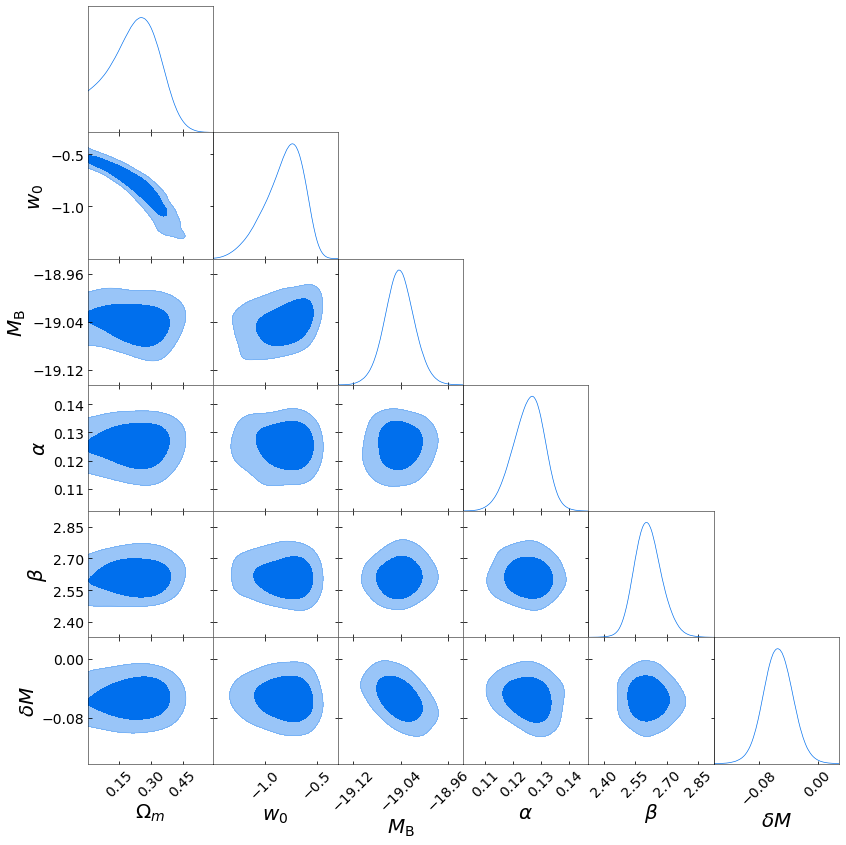

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


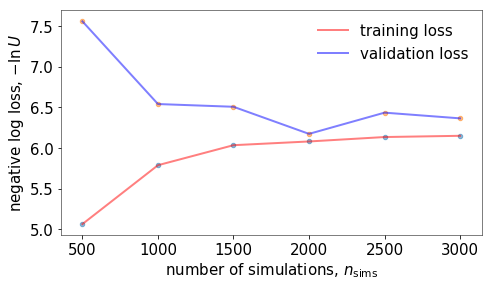

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2771, Val_loss: 6.4391
Epoch 00001, Train_loss: 6.2694, Val_loss: 6.4524
Epoch 00002, Train_loss: 6.2615, Val_loss: 6.4548
Epoch 00003, Train_loss: 6.2555, Val_loss: 6.4556
Epoch 00004, Train_loss: 6.2500, Val_loss: 6.4609
Epoch 00005, Train_loss: 6.2438, Val_loss: 6.4631
Epoch 00006, Train_loss: 6.2375, Val_loss: 6.4607
Epoch 00007, Train_loss: 6.2325, Val_loss: 6.4660
Epoch 00008, Train_loss: 6.2272, Val_loss: 6.4693
Epoch 00009, Train_loss: 6.2277, Val_loss: 6.4694
Epoch 00010, Train_loss: 6.2189, Val_loss: 6.4694
Epoch 00011, Train_loss: 6.2163, Val_loss: 6.4782
Epoch 00012, Train_loss: 6.2107, Val_loss: 6.4714
Epoch 00013, Train_loss: 6.2086, Val_loss: 6.4822
Epoch 00014, Train_loss: 6.2047, Val_loss: 6.4720
Epoch 00015, Train_loss: 6.1987, Val_loss: 6.4810
Epoch 00016, Train_loss: 6.1989, Val_loss: 6.4882
Epoch 00017, Train_loss: 6.2019, Val_loss: 6.4938
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_6.pdf


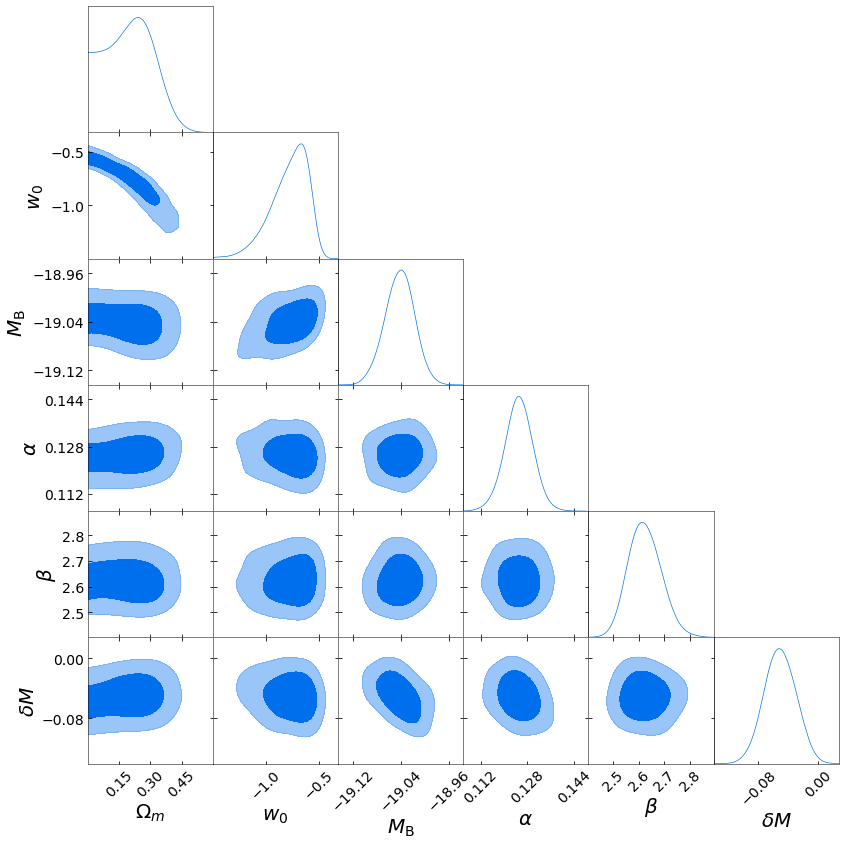

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


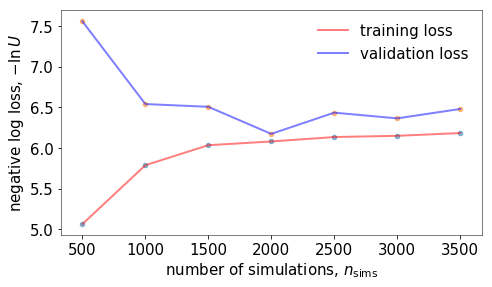

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2878, Val_loss: 6.2869
Epoch 00001, Train_loss: 6.2792, Val_loss: 6.2794
Epoch 00002, Train_loss: 6.2718, Val_loss: 6.2833
Epoch 00003, Train_loss: 6.2654, Val_loss: 6.2854
Epoch 00004, Train_loss: 6.2591, Val_loss: 6.2920
Epoch 00005, Train_loss: 6.2594, Val_loss: 6.2819
Epoch 00006, Train_loss: 6.2492, Val_loss: 6.2891
Epoch 00007, Train_loss: 6.2447, Val_loss: 6.2878
Epoch 00008, Train_loss: 6.2399, Val_loss: 6.2864
Epoch 00009, Train_loss: 6.2347, Val_loss: 6.2872
Epoch 00010, Train_loss: 6.2314, Val_loss: 6.2872
Epoch 00011, Train_loss: 6.2267, Val_loss: 6.2924
Epoch 00012, Train_loss: 6.2293, Val_loss: 6.2998
Epoch 00013, Train_loss: 6.2200, Val_loss: 6.2912
Epoch 00014, Train_loss: 6.2161, Val_loss: 6.2989
Epoch 00015, Train_loss: 6.2127, Val_loss: 6.2975
Epoch 00016, Train_loss: 6.2099, Val_loss: 6.2972
Epoch 00017, Train_loss: 6.2067, Val_loss: 6.2959
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_7.pdf


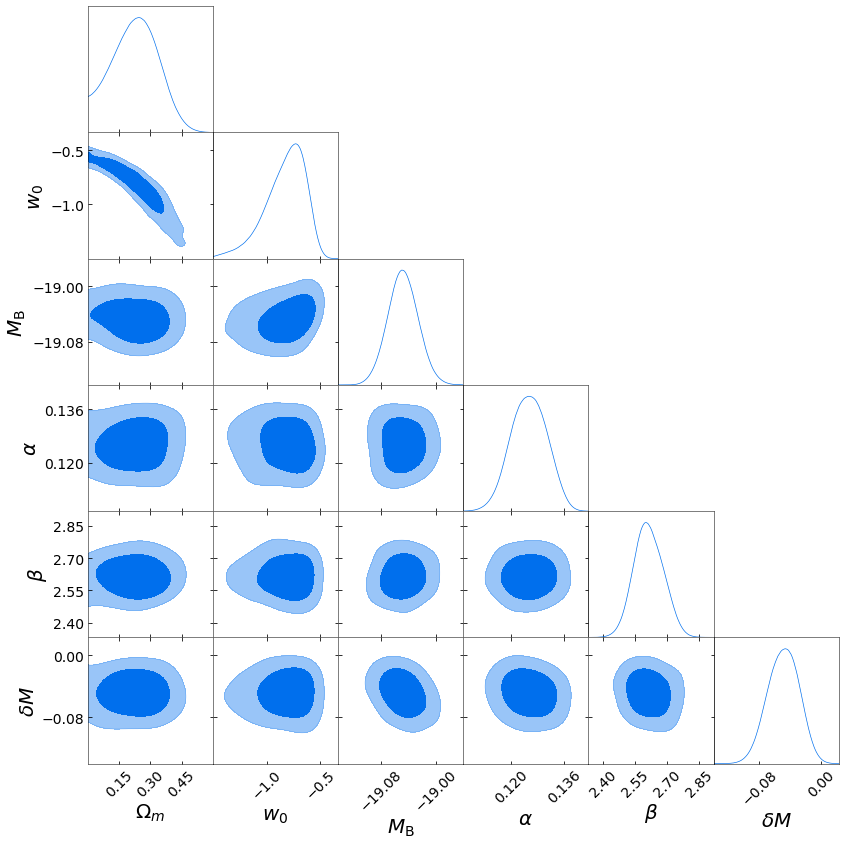

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


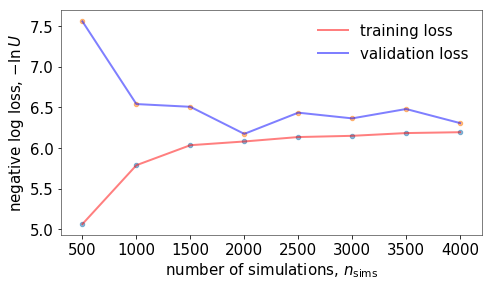

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3092, Val_loss: 6.2388
Epoch 00001, Train_loss: 6.3029, Val_loss: 6.2321
Epoch 00002, Train_loss: 6.2970, Val_loss: 6.2450
Epoch 00003, Train_loss: 6.2899, Val_loss: 6.2333
Epoch 00004, Train_loss: 6.2836, Val_loss: 6.2285
Epoch 00005, Train_loss: 6.2781, Val_loss: 6.2325
Epoch 00006, Train_loss: 6.2738, Val_loss: 6.2282
Epoch 00007, Train_loss: 6.2704, Val_loss: 6.2459
Epoch 00008, Train_loss: 6.2700, Val_loss: 6.2488
Epoch 00009, Train_loss: 6.2643, Val_loss: 6.2331
Epoch 00010, Train_loss: 6.2607, Val_loss: 6.2318
Epoch 00011, Train_loss: 6.2546, Val_loss: 6.2376
Epoch 00012, Train_loss: 6.2510, Val_loss: 6.2370
Epoch 00013, Train_loss: 6.2519, Val_loss: 6.2596
Epoch 00014, Train_loss: 6.2448, Val_loss: 6.2349
Epoch 00015, Train_loss: 6.2412, Val_loss: 6.2405
Epoch 00016, Train_loss: 6.2407, Val_loss: 6.2464
Epoch 00017, Train_loss: 6.2410, Val_loss: 6.2637
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_8.pdf


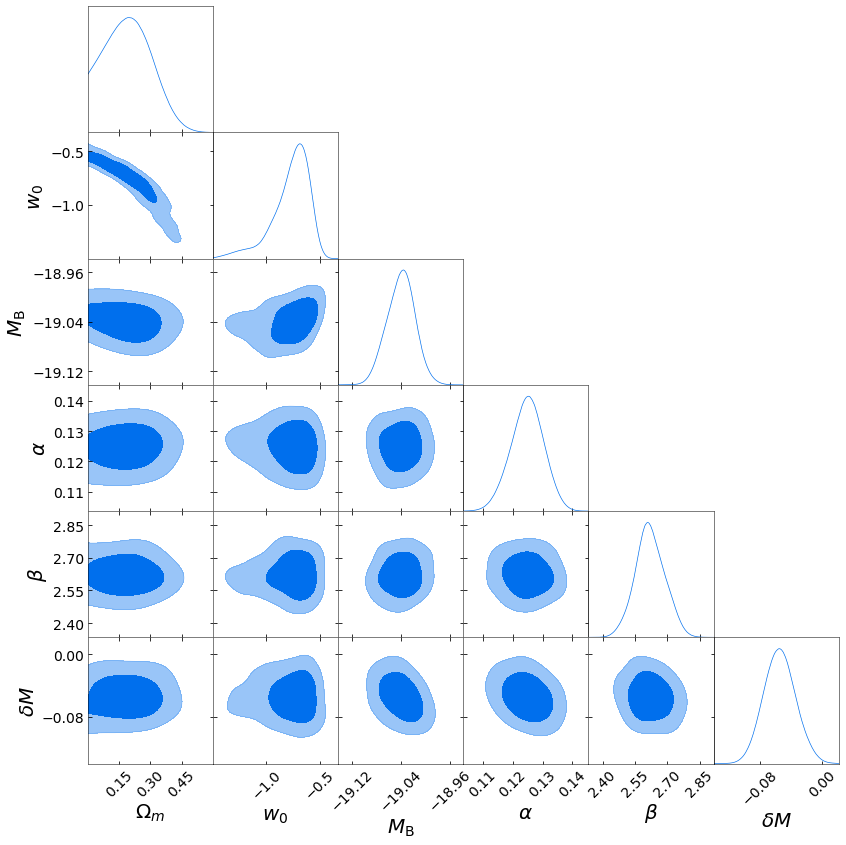

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


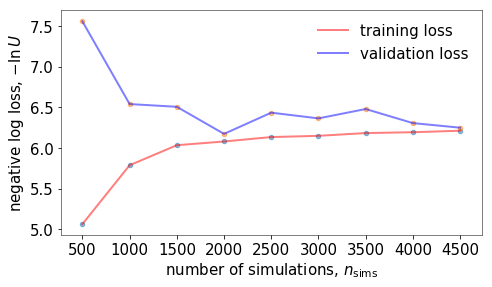

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2705, Val_loss: 6.3069
Epoch 00001, Train_loss: 6.2673, Val_loss: 6.3104
Epoch 00002, Train_loss: 6.2637, Val_loss: 6.3145
Epoch 00003, Train_loss: 6.2571, Val_loss: 6.3107
Epoch 00004, Train_loss: 6.2536, Val_loss: 6.3122
Epoch 00005, Train_loss: 6.2485, Val_loss: 6.3144
Epoch 00006, Train_loss: 6.2453, Val_loss: 6.3122
Epoch 00007, Train_loss: 6.2413, Val_loss: 6.3114
Epoch 00008, Train_loss: 6.2405, Val_loss: 6.3178
Epoch 00009, Train_loss: 6.2363, Val_loss: 6.3093
Epoch 00010, Train_loss: 6.2332, Val_loss: 6.3193
Epoch 00011, Train_loss: 6.2297, Val_loss: 6.3089
Epoch 00012, Train_loss: 6.2263, Val_loss: 6.3138
Epoch 00013, Train_loss: 6.2276, Val_loss: 6.3206
Epoch 00014, Train_loss: 6.2286, Val_loss: 6.3233
Epoch 00015, Train_loss: 6.2201, Val_loss: 6.3156
Epoch 00016, Train_loss: 6.2290, Val_loss: 6.3206
Epoch 00017, Train_loss: 6.2145, Val_loss: 6.3125
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_9.pdf


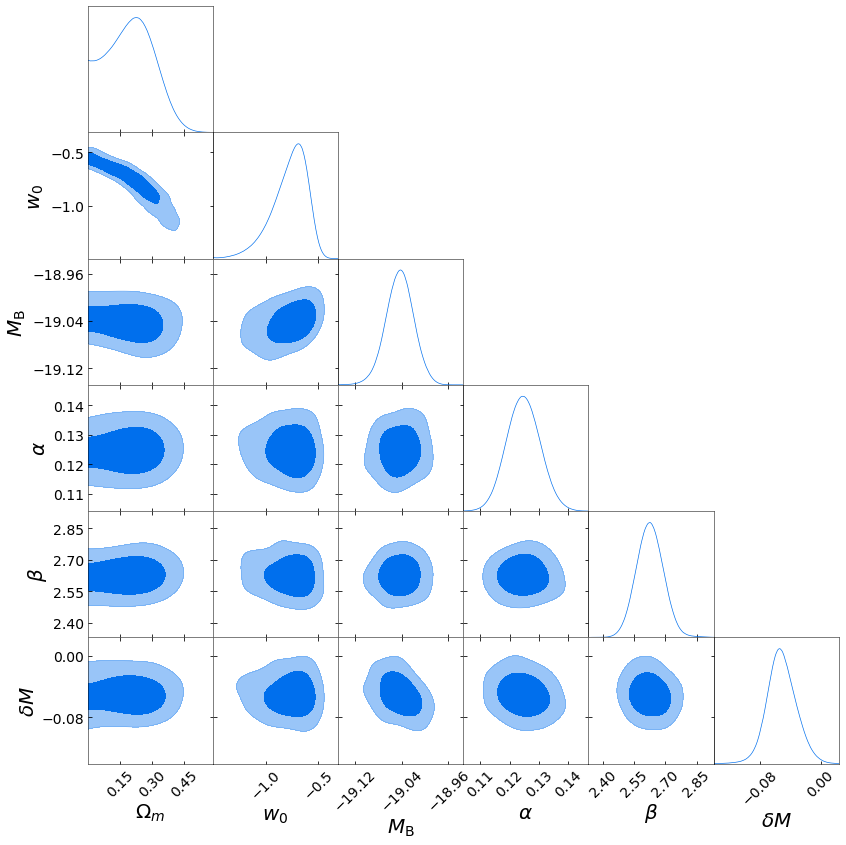

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


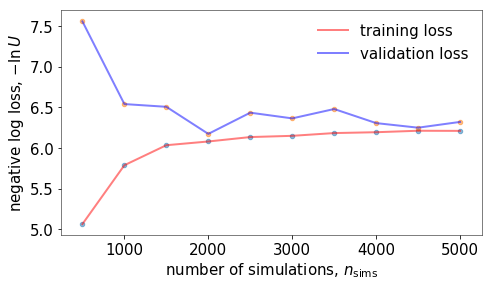

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2784, Val_loss: 6.3405
Epoch 00001, Train_loss: 6.2742, Val_loss: 6.3384
Epoch 00002, Train_loss: 6.2708, Val_loss: 6.3492
Epoch 00003, Train_loss: 6.2670, Val_loss: 6.3454
Epoch 00004, Train_loss: 6.2657, Val_loss: 6.3498
Epoch 00005, Train_loss: 6.2568, Val_loss: 6.3467
Epoch 00006, Train_loss: 6.2565, Val_loss: 6.3444
Epoch 00007, Train_loss: 6.2511, Val_loss: 6.3441
Epoch 00008, Train_loss: 6.2486, Val_loss: 6.3459
Epoch 00009, Train_loss: 6.2557, Val_loss: 6.3616
Epoch 00010, Train_loss: 6.2423, Val_loss: 6.3392
Epoch 00011, Train_loss: 6.2405, Val_loss: 6.3507
Epoch 00012, Train_loss: 6.2366, Val_loss: 6.3471
Epoch 00013, Train_loss: 6.2341, Val_loss: 6.3482
Epoch 00014, Train_loss: 6.2317, Val_loss: 6.3445
Epoch 00015, Train_loss: 6.2297, Val_loss: 6.3500
Epoch 00016, Train_loss: 6.2288, Val_loss: 6.3493
Epoch 00017, Train_loss: 6.2243, Val_loss: 6.3464
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_10.pdf


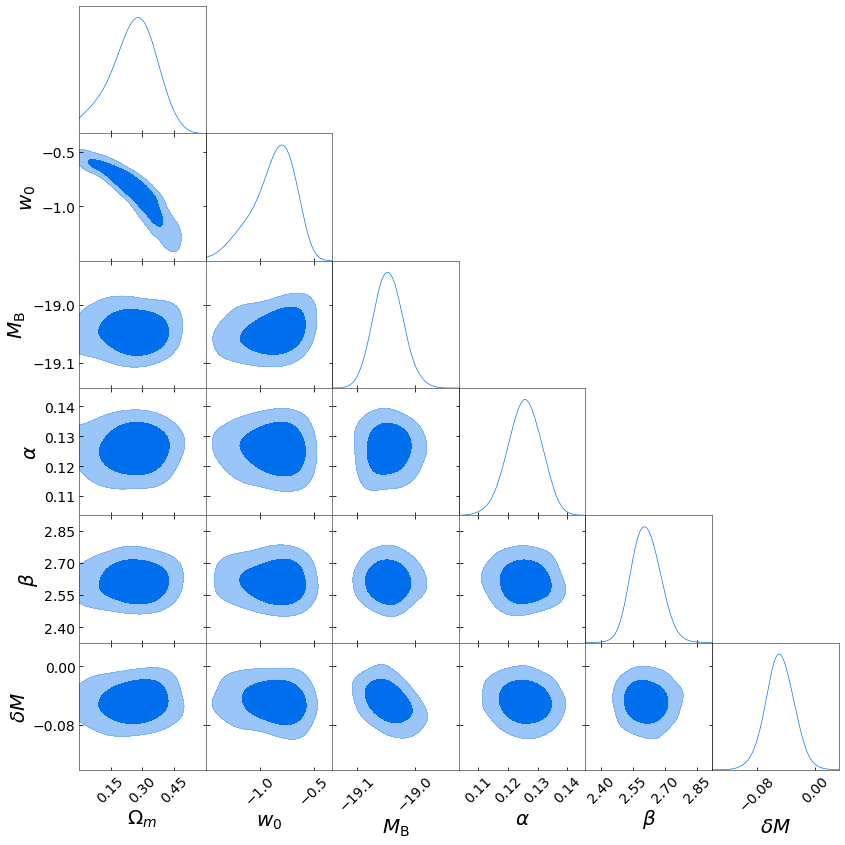

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


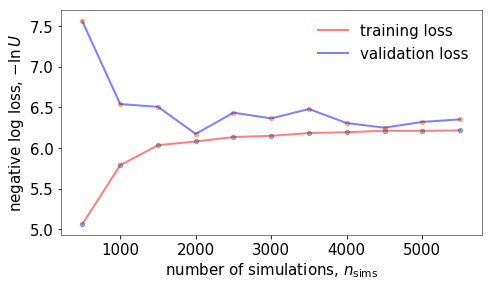

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2931, Val_loss: 6.2805
Epoch 00001, Train_loss: 6.2866, Val_loss: 6.2866
Epoch 00002, Train_loss: 6.2829, Val_loss: 6.2911
Epoch 00003, Train_loss: 6.2789, Val_loss: 6.2950
Epoch 00004, Train_loss: 6.2801, Val_loss: 6.3028
Epoch 00005, Train_loss: 6.2729, Val_loss: 6.2891
Epoch 00006, Train_loss: 6.2712, Val_loss: 6.2954
Epoch 00007, Train_loss: 6.2666, Val_loss: 6.2937
Epoch 00008, Train_loss: 6.2655, Val_loss: 6.3003
Epoch 00009, Train_loss: 6.2639, Val_loss: 6.3058
Epoch 00010, Train_loss: 6.2599, Val_loss: 6.2957
Epoch 00011, Train_loss: 6.2554, Val_loss: 6.2967
Epoch 00012, Train_loss: 6.2608, Val_loss: 6.3122
Epoch 00013, Train_loss: 6.2515, Val_loss: 6.3011
Epoch 00014, Train_loss: 6.2538, Val_loss: 6.2967
Epoch 00015, Train_loss: 6.2470, Val_loss: 6.3004
Epoch 00016, Train_loss: 6.2467, Val_loss: 6.3051
Epoch 00017, Train_loss: 6.2485, Val_loss: 6.3145
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_11.pdf


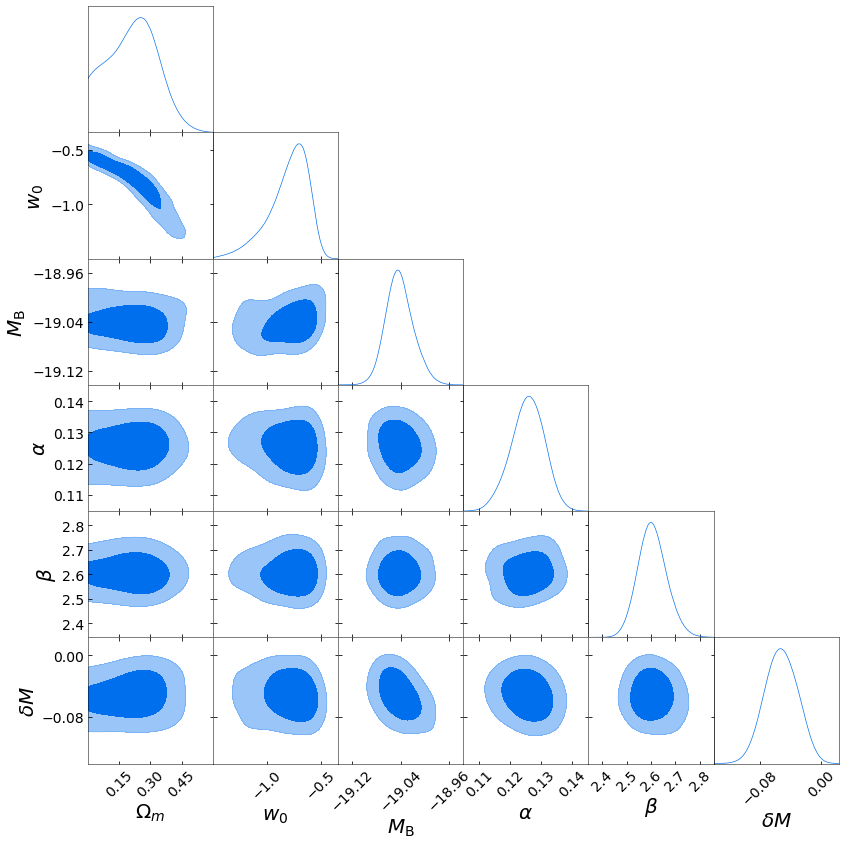

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


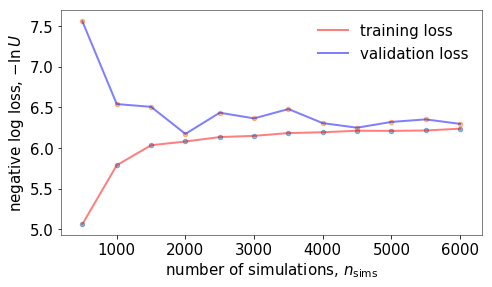

Population 12/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3034, Val_loss: 6.2699
Epoch 00001, Train_loss: 6.2961, Val_loss: 6.2721
Epoch 00002, Train_loss: 6.2959, Val_loss: 6.2733
Epoch 00003, Train_loss: 6.2884, Val_loss: 6.2756
Epoch 00004, Train_loss: 6.2855, Val_loss: 6.2773
Epoch 00005, Train_loss: 6.2838, Val_loss: 6.2746
Epoch 00006, Train_loss: 6.2802, Val_loss: 6.2773
Epoch 00007, Train_loss: 6.2843, Val_loss: 6.2810
Epoch 00008, Train_loss: 6.2748, Val_loss: 6.2755
Epoch 00009, Train_loss: 6.2725, Val_loss: 6.2798
Epoch 00010, Train_loss: 6.2724, Val_loss: 6.2810
Epoch 00011, Train_loss: 6.2686, Val_loss: 6.2780
Epoch 00012, Train_loss: 6.2718, Val_loss: 6.2921
Epoch 00013, Train_loss: 6.2632, Val_loss: 6.2801
Epoch 00014, Train_loss: 6.2678, Val_loss: 6.2838
Epoch 00015, Train_loss: 6.2602, Val_loss: 6.2811
Epoch 00016, Train_loss: 6.2568, Val_loss: 6.2810
Epoch 00017, Train_loss: 6.2566, Val_loss: 6.2802
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_12.pdf


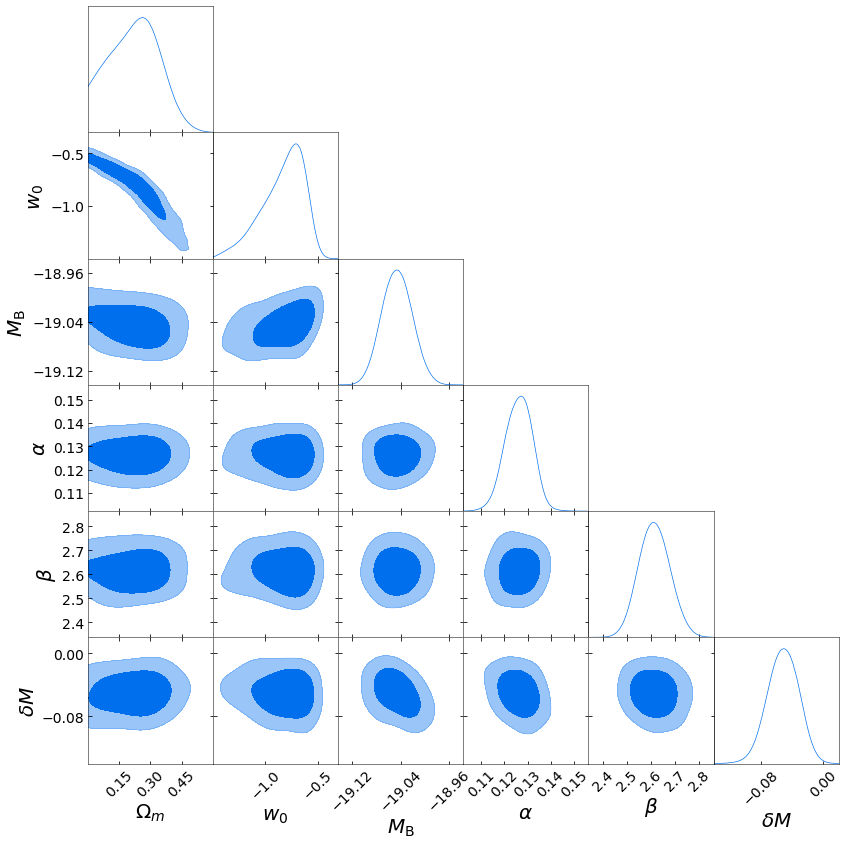

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


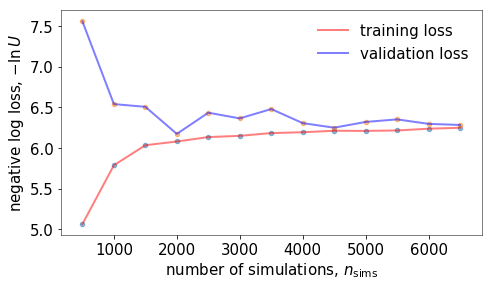

Population 13/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2979, Val_loss: 6.3103
Epoch 00001, Train_loss: 6.2945, Val_loss: 6.3144
Epoch 00002, Train_loss: 6.2864, Val_loss: 6.3040
Epoch 00003, Train_loss: 6.2853, Val_loss: 6.3055
Epoch 00004, Train_loss: 6.2786, Val_loss: 6.3090
Epoch 00005, Train_loss: 6.2770, Val_loss: 6.3092
Epoch 00006, Train_loss: 6.2722, Val_loss: 6.3041
Epoch 00007, Train_loss: 6.2715, Val_loss: 6.3110
Epoch 00008, Train_loss: 6.2679, Val_loss: 6.3081
Epoch 00009, Train_loss: 6.2647, Val_loss: 6.3054
Epoch 00010, Train_loss: 6.2665, Val_loss: 6.3141
Epoch 00011, Train_loss: 6.2604, Val_loss: 6.3062
Epoch 00012, Train_loss: 6.2587, Val_loss: 6.3140
Epoch 00013, Train_loss: 6.2563, Val_loss: 6.3046
Epoch 00014, Train_loss: 6.2535, Val_loss: 6.3107
Epoch 00015, Train_loss: 6.2524, Val_loss: 6.3151
Epoch 00016, Train_loss: 6.2496, Val_loss: 6.3100
Epoch 00017, Train_loss: 6.2487, Val_loss: 6.3121
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_13.pdf


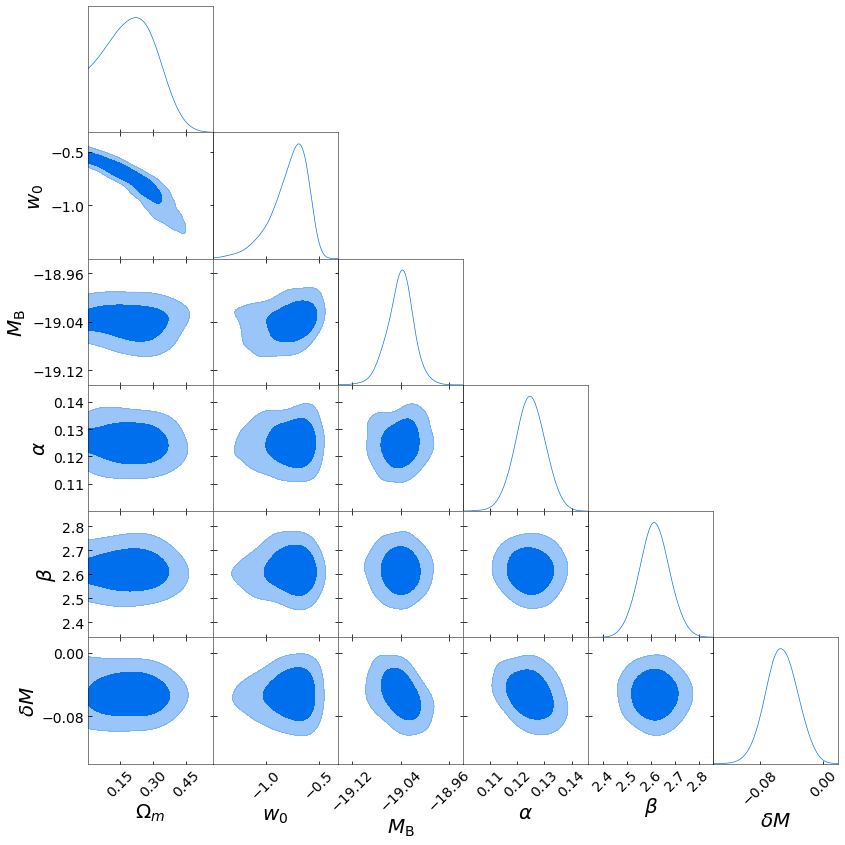

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


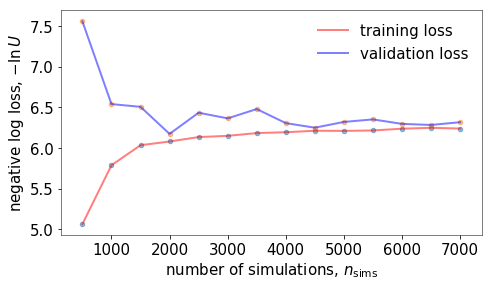

Population 14/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3000, Val_loss: 6.2922
Epoch 00001, Train_loss: 6.2942, Val_loss: 6.2960
Epoch 00002, Train_loss: 6.2924, Val_loss: 6.2978
Epoch 00003, Train_loss: 6.2854, Val_loss: 6.2977
Epoch 00004, Train_loss: 6.2836, Val_loss: 6.2912
Epoch 00005, Train_loss: 6.2803, Val_loss: 6.3039
Epoch 00006, Train_loss: 6.2811, Val_loss: 6.2986
Epoch 00007, Train_loss: 6.2749, Val_loss: 6.3020
Epoch 00008, Train_loss: 6.2752, Val_loss: 6.3017
Epoch 00009, Train_loss: 6.2697, Val_loss: 6.3016
Epoch 00010, Train_loss: 6.2695, Val_loss: 6.3044
Epoch 00011, Train_loss: 6.2673, Val_loss: 6.3040
Epoch 00012, Train_loss: 6.2637, Val_loss: 6.3023
Epoch 00013, Train_loss: 6.2628, Val_loss: 6.3045
Epoch 00014, Train_loss: 6.2593, Val_loss: 6.3041
Epoch 00015, Train_loss: 6.2604, Val_loss: 6.3046
Epoch 00016, Train_loss: 6.2557, Val_loss: 6.3041
Epoch 00017, Train_loss: 6.2555, Val_loss: 6.3031
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_14.pdf


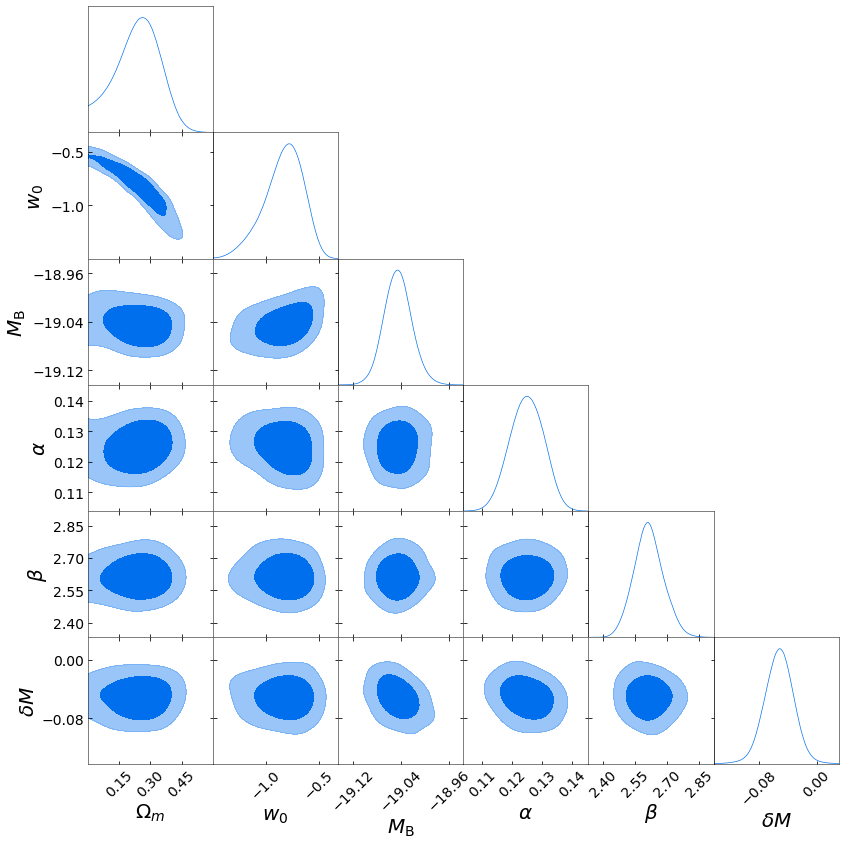

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


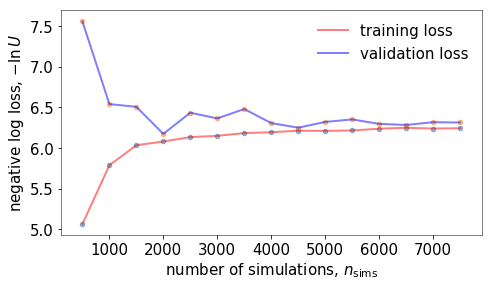

Population 15/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2949, Val_loss: 6.2656
Epoch 00001, Train_loss: 6.2916, Val_loss: 6.2672
Epoch 00002, Train_loss: 6.2889, Val_loss: 6.2733
Epoch 00003, Train_loss: 6.2868, Val_loss: 6.2722
Epoch 00004, Train_loss: 6.2849, Val_loss: 6.2737
Epoch 00005, Train_loss: 6.2816, Val_loss: 6.2737
Epoch 00006, Train_loss: 6.2791, Val_loss: 6.2730
Epoch 00007, Train_loss: 6.2775, Val_loss: 6.2743
Epoch 00008, Train_loss: 6.2771, Val_loss: 6.2777
Epoch 00009, Train_loss: 6.2748, Val_loss: 6.2739
Epoch 00010, Train_loss: 6.2718, Val_loss: 6.2762
Epoch 00011, Train_loss: 6.2721, Val_loss: 6.2774
Epoch 00012, Train_loss: 6.2734, Val_loss: 6.2815
Epoch 00013, Train_loss: 6.2685, Val_loss: 6.2775
Epoch 00014, Train_loss: 6.2658, Val_loss: 6.2789
Epoch 00015, Train_loss: 6.2633, Val_loss: 6.2779
Epoch 00016, Train_loss: 6.2625, Val_loss: 6.2763
Epoch 00017, Train_loss: 6.2606, Val_loss: 6.2792
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_15.pdf


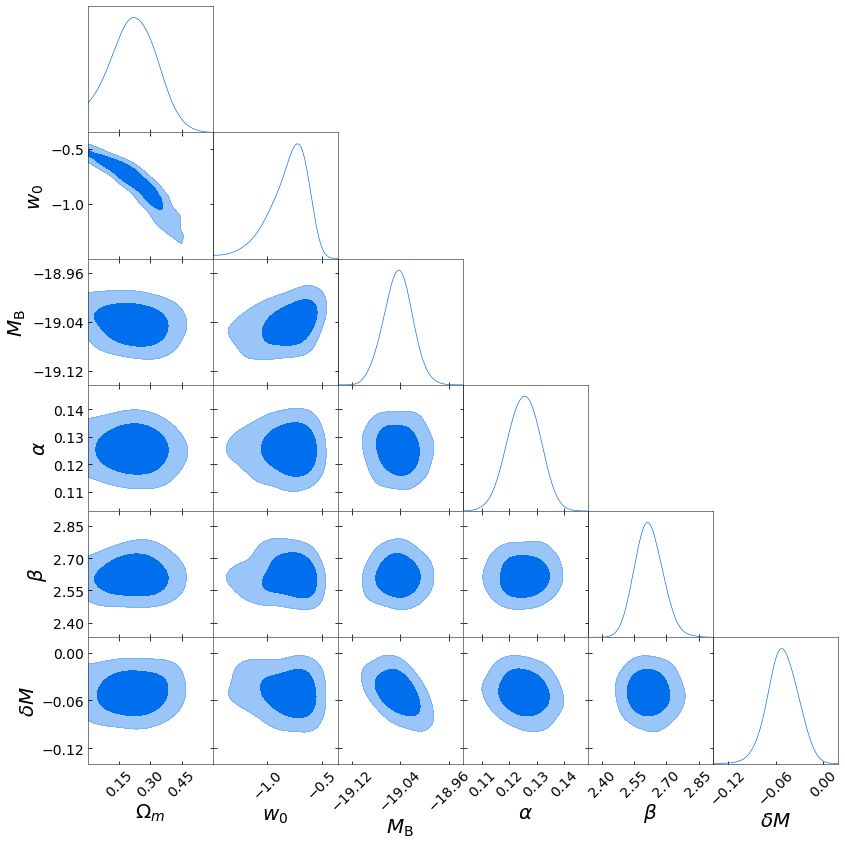

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


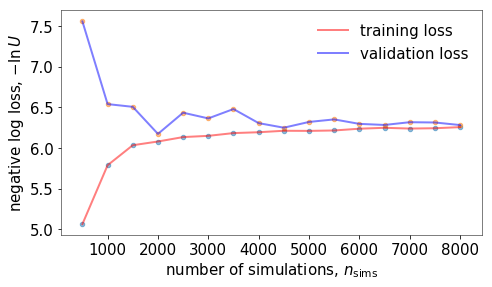

Population 16/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2967, Val_loss: 6.2810
Epoch 00001, Train_loss: 6.2940, Val_loss: 6.2824
Epoch 00002, Train_loss: 6.2919, Val_loss: 6.2854
Epoch 00003, Train_loss: 6.2882, Val_loss: 6.2872
Epoch 00004, Train_loss: 6.2863, Val_loss: 6.2906
Epoch 00005, Train_loss: 6.2856, Val_loss: 6.2937
Epoch 00006, Train_loss: 6.2846, Val_loss: 6.2951
Epoch 00007, Train_loss: 6.2804, Val_loss: 6.2941
Epoch 00008, Train_loss: 6.2784, Val_loss: 6.2911
Epoch 00009, Train_loss: 6.2759, Val_loss: 6.2961
Epoch 00010, Train_loss: 6.2765, Val_loss: 6.3016
Epoch 00011, Train_loss: 6.2725, Val_loss: 6.2953
Epoch 00012, Train_loss: 6.2707, Val_loss: 6.2989
Epoch 00013, Train_loss: 6.2699, Val_loss: 6.2987
Epoch 00014, Train_loss: 6.2678, Val_loss: 6.3008
Epoch 00015, Train_loss: 6.2667, Val_loss: 6.2966
Epoch 00016, Train_loss: 6.2658, Val_loss: 6.3044
Epoch 00017, Train_loss: 6.2631, Val_loss: 6.2988
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_16.pdf


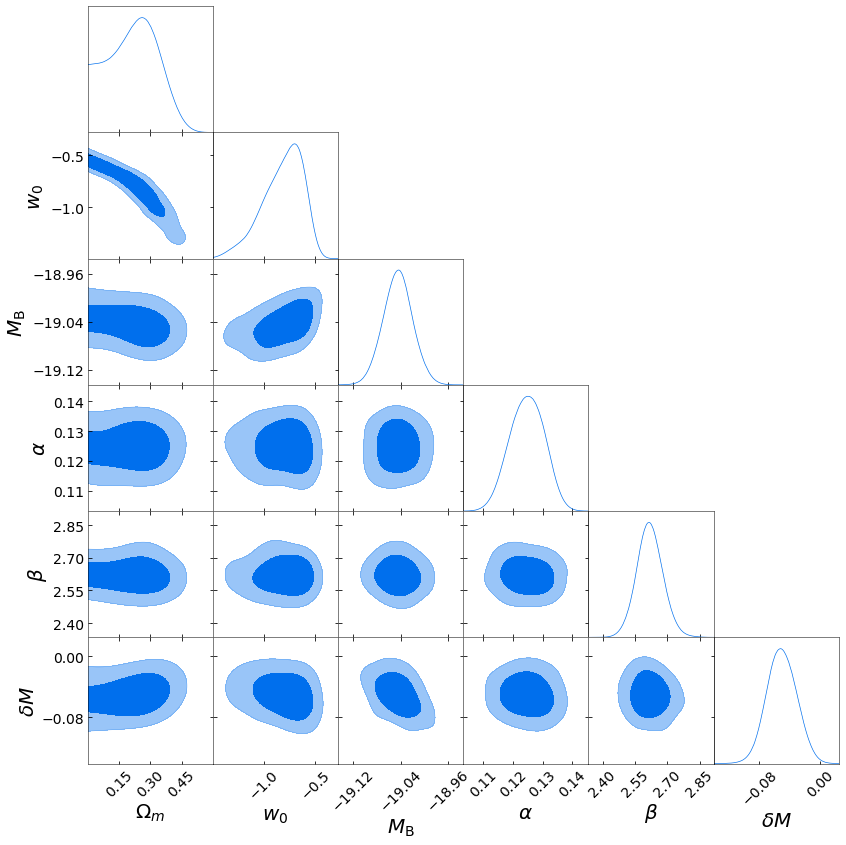

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


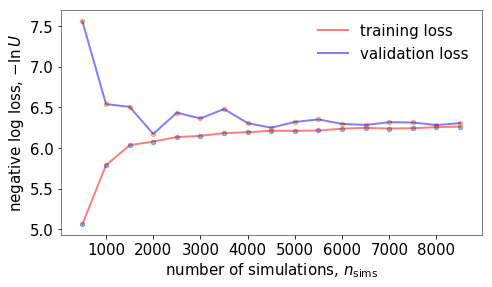

Population 17/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2930, Val_loss: 6.3403
Epoch 00001, Train_loss: 6.2901, Val_loss: 6.3451
Epoch 00002, Train_loss: 6.2884, Val_loss: 6.3441
Epoch 00003, Train_loss: 6.2847, Val_loss: 6.3461
Epoch 00004, Train_loss: 6.2861, Val_loss: 6.3477
Epoch 00005, Train_loss: 6.2805, Val_loss: 6.3482
Epoch 00006, Train_loss: 6.2871, Val_loss: 6.3541
Epoch 00007, Train_loss: 6.2772, Val_loss: 6.3509
Epoch 00008, Train_loss: 6.2762, Val_loss: 6.3505
Epoch 00009, Train_loss: 6.2772, Val_loss: 6.3510
Epoch 00010, Train_loss: 6.2709, Val_loss: 6.3468
Epoch 00011, Train_loss: 6.2705, Val_loss: 6.3540
Epoch 00012, Train_loss: 6.2684, Val_loss: 6.3513
Epoch 00013, Train_loss: 6.2672, Val_loss: 6.3524
Epoch 00014, Train_loss: 6.2646, Val_loss: 6.3551
Epoch 00015, Train_loss: 6.2643, Val_loss: 6.3522
Epoch 00016, Train_loss: 6.2617, Val_loss: 6.3479
Epoch 00017, Train_loss: 6.2617, Val_loss: 6.3561
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_17.pdf


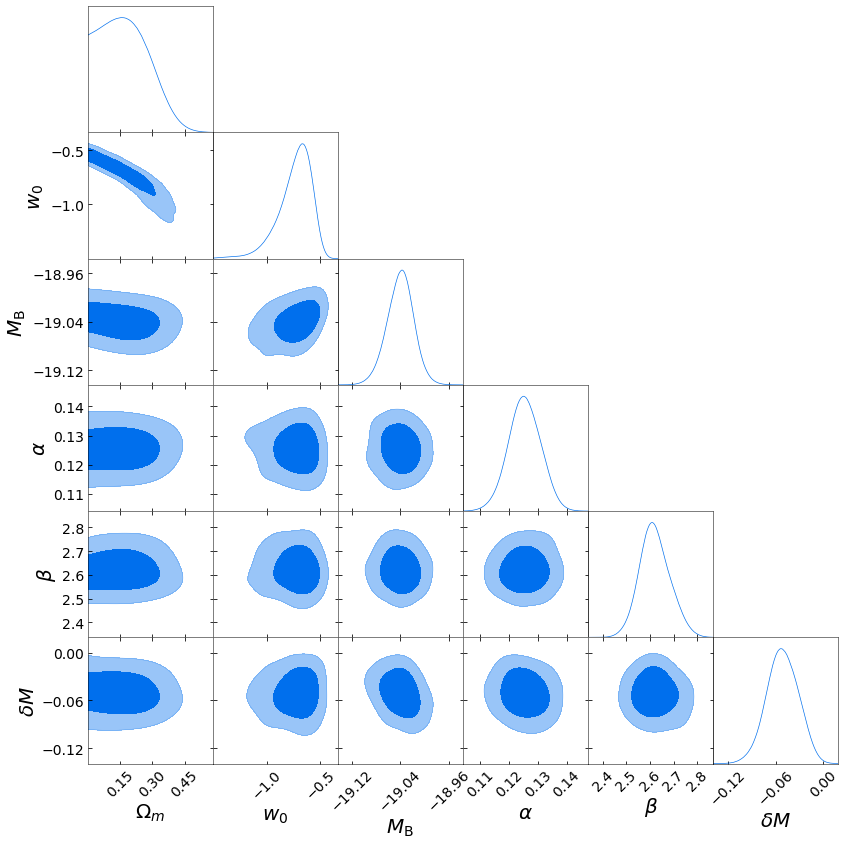

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


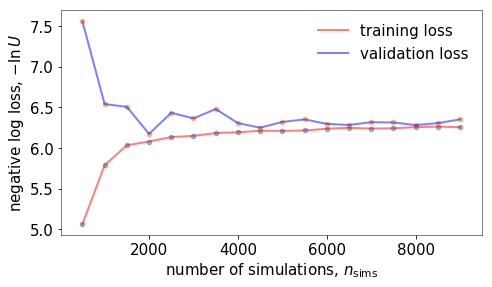

Population 18/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2946, Val_loss: 6.2936
Epoch 00001, Train_loss: 6.2910, Val_loss: 6.2975
Epoch 00002, Train_loss: 6.2886, Val_loss: 6.2945
Epoch 00003, Train_loss: 6.2871, Val_loss: 6.2986
Epoch 00004, Train_loss: 6.2842, Val_loss: 6.2986
Epoch 00005, Train_loss: 6.2828, Val_loss: 6.2985
Epoch 00006, Train_loss: 6.2809, Val_loss: 6.3017
Epoch 00007, Train_loss: 6.2784, Val_loss: 6.2967
Epoch 00008, Train_loss: 6.2768, Val_loss: 6.2986
Epoch 00009, Train_loss: 6.2754, Val_loss: 6.2998
Epoch 00010, Train_loss: 6.2764, Val_loss: 6.2990
Epoch 00011, Train_loss: 6.2713, Val_loss: 6.3008
Epoch 00012, Train_loss: 6.2696, Val_loss: 6.3000
Epoch 00013, Train_loss: 6.2689, Val_loss: 6.3031
Epoch 00014, Train_loss: 6.2686, Val_loss: 6.3001
Epoch 00015, Train_loss: 6.2655, Val_loss: 6.3037
Epoch 00016, Train_loss: 6.2651, Val_loss: 6.2993
Epoch 00017, Train_loss: 6.2626, Val_loss: 6.3009
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_18.pdf


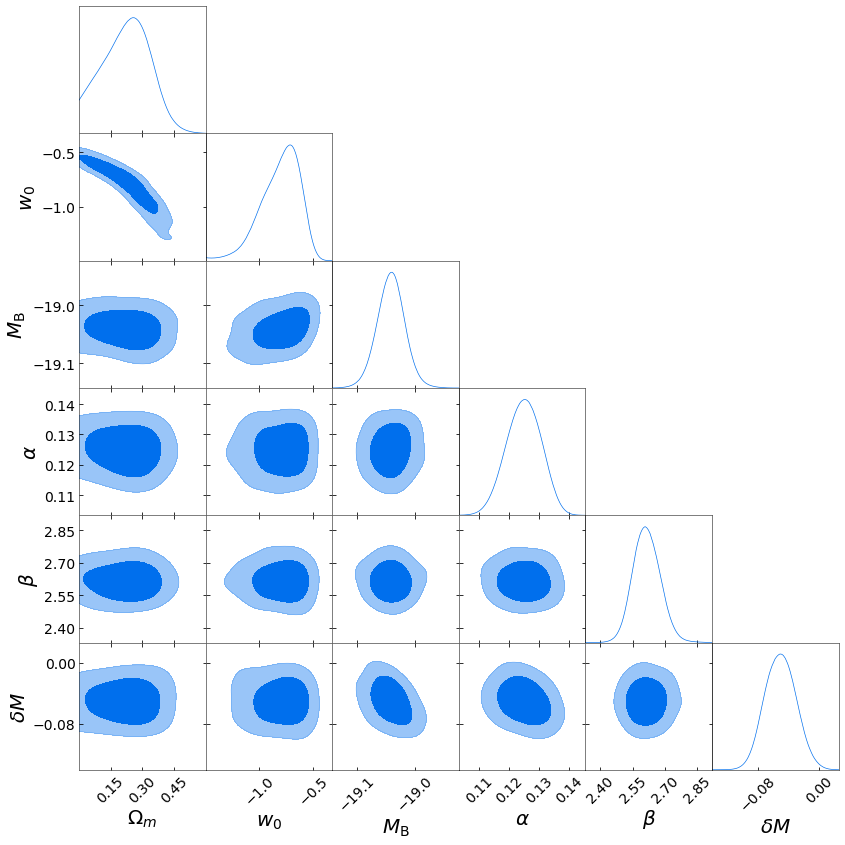

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


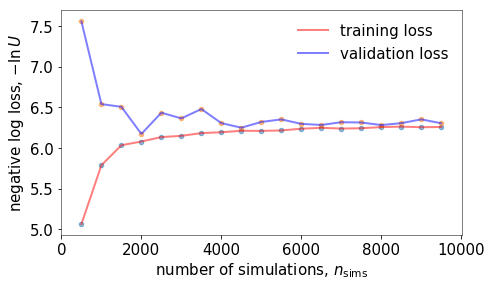

Population 19/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3001, Val_loss: 6.2516
Epoch 00001, Train_loss: 6.2978, Val_loss: 6.2525
Epoch 00002, Train_loss: 6.3021, Val_loss: 6.2625
Epoch 00003, Train_loss: 6.2929, Val_loss: 6.2551
Epoch 00004, Train_loss: 6.2911, Val_loss: 6.2561
Epoch 00005, Train_loss: 6.2891, Val_loss: 6.2577
Epoch 00006, Train_loss: 6.2864, Val_loss: 6.2536
Epoch 00007, Train_loss: 6.2846, Val_loss: 6.2574
Epoch 00008, Train_loss: 6.2836, Val_loss: 6.2597
Epoch 00009, Train_loss: 6.2844, Val_loss: 6.2594
Epoch 00010, Train_loss: 6.2884, Val_loss: 6.2688
Epoch 00011, Train_loss: 6.2783, Val_loss: 6.2578
Epoch 00012, Train_loss: 6.2789, Val_loss: 6.2611
Epoch 00013, Train_loss: 6.2761, Val_loss: 6.2577
Epoch 00014, Train_loss: 6.2778, Val_loss: 6.2662
Epoch 00015, Train_loss: 6.2734, Val_loss: 6.2594
Epoch 00016, Train_loss: 6.2743, Val_loss: 6.2616
Epoch 00017, Train_loss: 6.2742, Val_loss: 6.2633
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_19.pdf


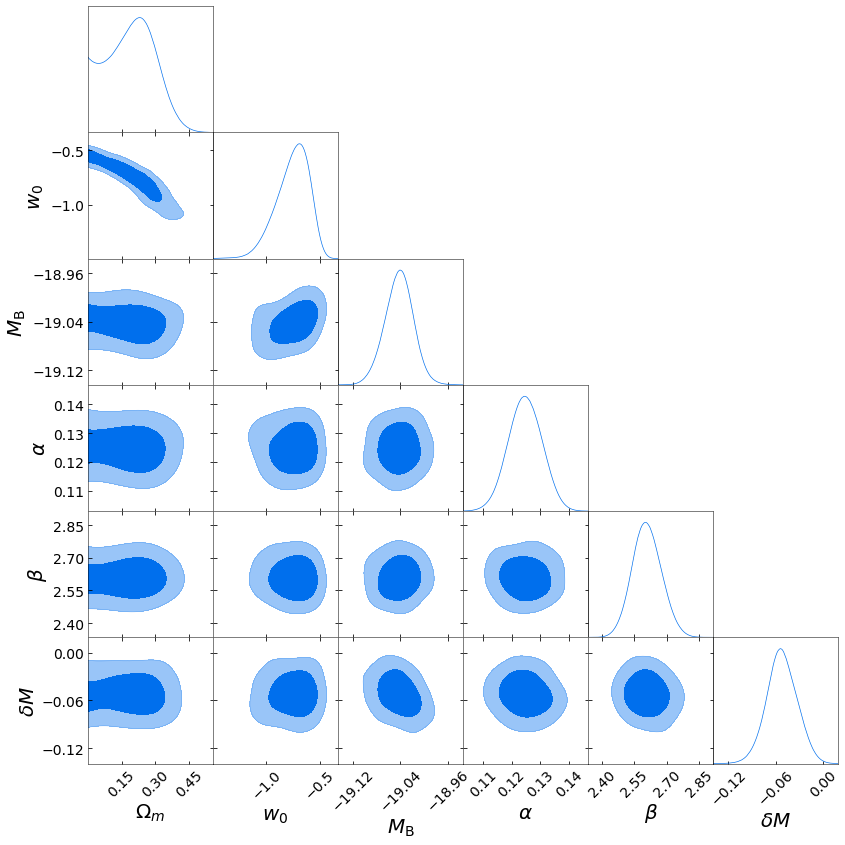

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


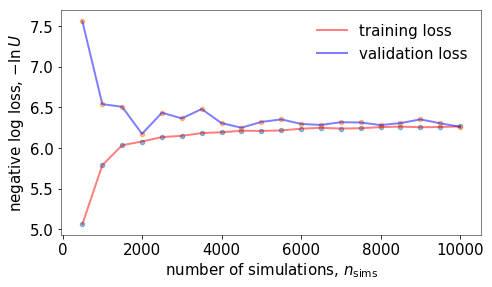

Population 20/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2806, Val_loss: 6.4158
Epoch 00001, Train_loss: 6.2757, Val_loss: 6.4198
Epoch 00002, Train_loss: 6.2728, Val_loss: 6.4178
Epoch 00003, Train_loss: 6.2716, Val_loss: 6.4198
Epoch 00004, Train_loss: 6.2706, Val_loss: 6.4264
Epoch 00005, Train_loss: 6.2680, Val_loss: 6.4172
Epoch 00006, Train_loss: 6.2662, Val_loss: 6.4223
Epoch 00007, Train_loss: 6.2661, Val_loss: 6.4250
Epoch 00008, Train_loss: 6.2632, Val_loss: 6.4244
Epoch 00009, Train_loss: 6.2613, Val_loss: 6.4202
Epoch 00010, Train_loss: 6.2602, Val_loss: 6.4197
Epoch 00011, Train_loss: 6.2593, Val_loss: 6.4260
Epoch 00012, Train_loss: 6.2566, Val_loss: 6.4240
Epoch 00013, Train_loss: 6.2547, Val_loss: 6.4222
Epoch 00014, Train_loss: 6.2555, Val_loss: 6.4223
Epoch 00015, Train_loss: 6.2538, Val_loss: 6.4271
Epoch 00016, Train_loss: 6.2509, Val_loss: 6.4223
Epoch 00017, Train_loss: 6.2504, Val_loss: 6.4208
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_20.pdf


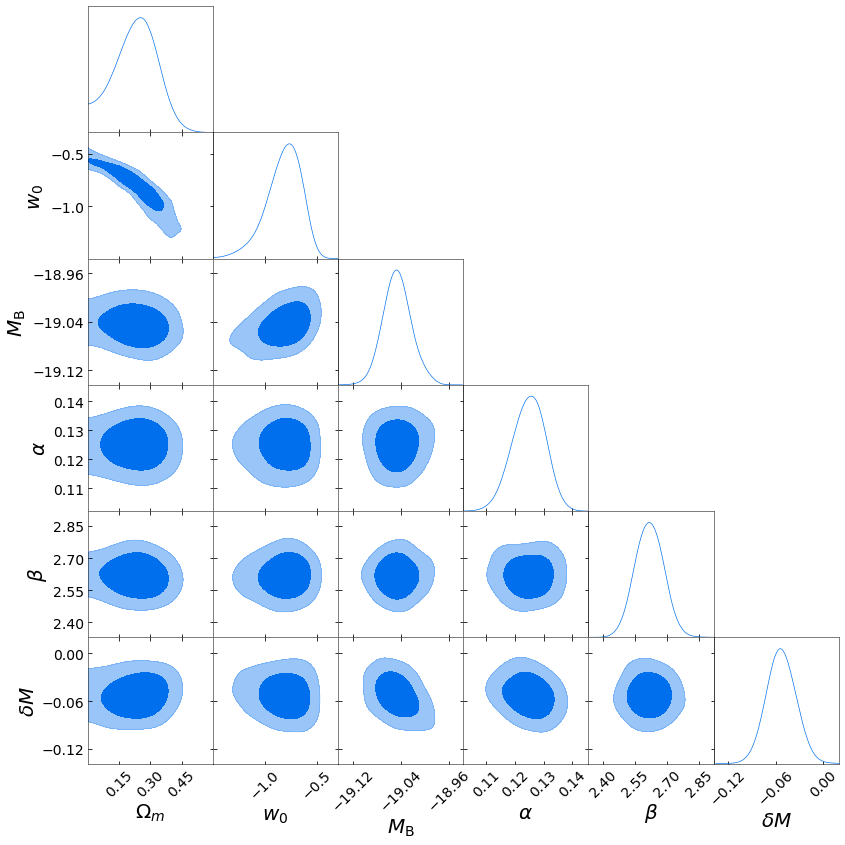

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


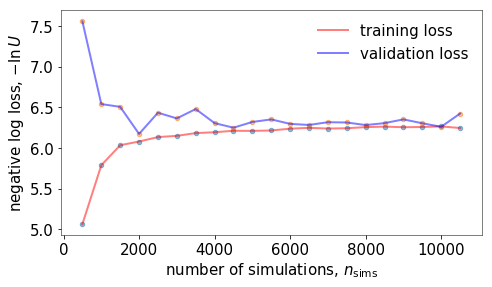

Population 21/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2920, Val_loss: 6.2966
Epoch 00001, Train_loss: 6.2899, Val_loss: 6.2979
Epoch 00002, Train_loss: 6.2873, Val_loss: 6.3017
Epoch 00003, Train_loss: 6.2849, Val_loss: 6.3032
Epoch 00004, Train_loss: 6.2831, Val_loss: 6.3011
Epoch 00005, Train_loss: 6.2815, Val_loss: 6.3041
Epoch 00006, Train_loss: 6.2810, Val_loss: 6.3077
Epoch 00007, Train_loss: 6.2785, Val_loss: 6.3074
Epoch 00008, Train_loss: 6.2765, Val_loss: 6.3059
Epoch 00009, Train_loss: 6.2745, Val_loss: 6.3049
Epoch 00010, Train_loss: 6.2728, Val_loss: 6.3064
Epoch 00011, Train_loss: 6.2713, Val_loss: 6.3084
Epoch 00012, Train_loss: 6.2708, Val_loss: 6.3040
Epoch 00013, Train_loss: 6.2694, Val_loss: 6.3069
Epoch 00014, Train_loss: 6.2677, Val_loss: 6.3078
Epoch 00015, Train_loss: 6.2662, Val_loss: 6.3117
Epoch 00016, Train_loss: 6.2647, Val_loss: 6.3089
Epoch 00017, Train_loss: 6.2642, Val_loss: 6.3092
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_21.pdf


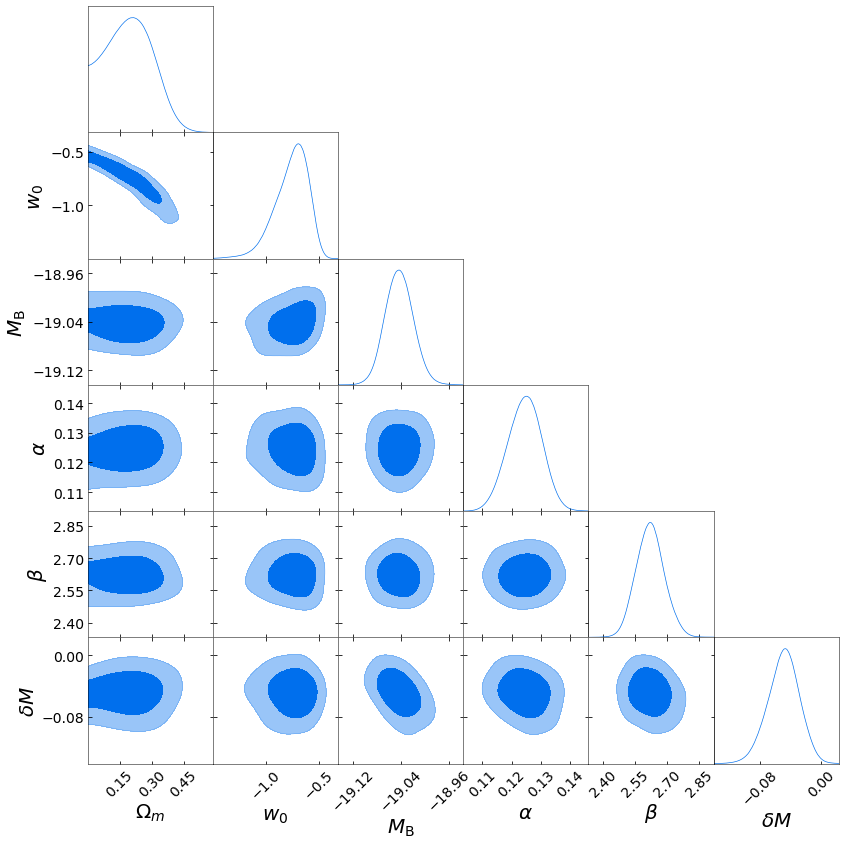

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


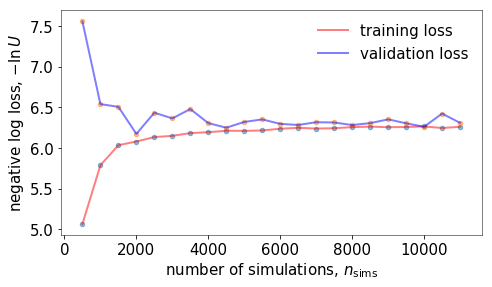

Population 22/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3013, Val_loss: 6.2475
Epoch 00001, Train_loss: 6.2984, Val_loss: 6.2496
Epoch 00002, Train_loss: 6.2965, Val_loss: 6.2476
Epoch 00003, Train_loss: 6.2972, Val_loss: 6.2552
Epoch 00004, Train_loss: 6.2931, Val_loss: 6.2504
Epoch 00005, Train_loss: 6.2906, Val_loss: 6.2499
Epoch 00006, Train_loss: 6.2895, Val_loss: 6.2489
Epoch 00007, Train_loss: 6.2878, Val_loss: 6.2529
Epoch 00008, Train_loss: 6.2856, Val_loss: 6.2518
Epoch 00009, Train_loss: 6.2857, Val_loss: 6.2540
Epoch 00010, Train_loss: 6.2828, Val_loss: 6.2474
Epoch 00011, Train_loss: 6.2823, Val_loss: 6.2537
Epoch 00012, Train_loss: 6.2823, Val_loss: 6.2526
Epoch 00013, Train_loss: 6.2791, Val_loss: 6.2505
Epoch 00014, Train_loss: 6.2801, Val_loss: 6.2548
Epoch 00015, Train_loss: 6.2797, Val_loss: 6.2563
Epoch 00016, Train_loss: 6.2747, Val_loss: 6.2520
Epoch 00017, Train_loss: 6.2755, Val_loss: 6.2521
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_22.pdf


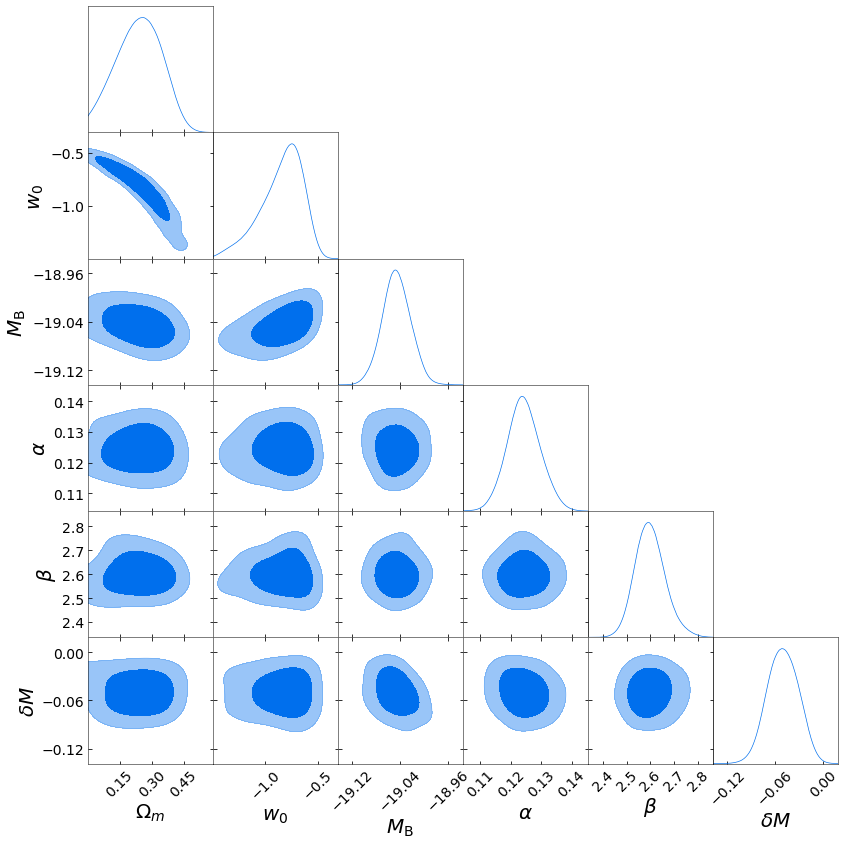

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


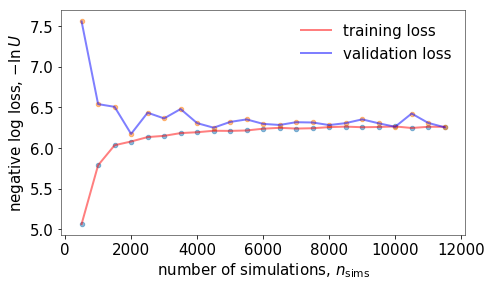

Population 23/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2880, Val_loss: 6.2415
Epoch 00001, Train_loss: 6.2864, Val_loss: 6.2465
Epoch 00002, Train_loss: 6.2854, Val_loss: 6.2461
Epoch 00003, Train_loss: 6.2826, Val_loss: 6.2489
Epoch 00004, Train_loss: 6.2812, Val_loss: 6.2485
Epoch 00005, Train_loss: 6.2802, Val_loss: 6.2458
Epoch 00006, Train_loss: 6.2794, Val_loss: 6.2486
Epoch 00007, Train_loss: 6.2778, Val_loss: 6.2495
Epoch 00008, Train_loss: 6.2767, Val_loss: 6.2512
Epoch 00009, Train_loss: 6.2753, Val_loss: 6.2518
Epoch 00010, Train_loss: 6.2762, Val_loss: 6.2550
Epoch 00011, Train_loss: 6.2754, Val_loss: 6.2579
Epoch 00012, Train_loss: 6.2722, Val_loss: 6.2520
Epoch 00013, Train_loss: 6.2708, Val_loss: 6.2505
Epoch 00014, Train_loss: 6.2712, Val_loss: 6.2514
Epoch 00015, Train_loss: 6.2690, Val_loss: 6.2518
Epoch 00016, Train_loss: 6.2679, Val_loss: 6.2507
Epoch 00017, Train_loss: 6.2670, Val_loss: 6.2518
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mafseq_train_post_23.pdf


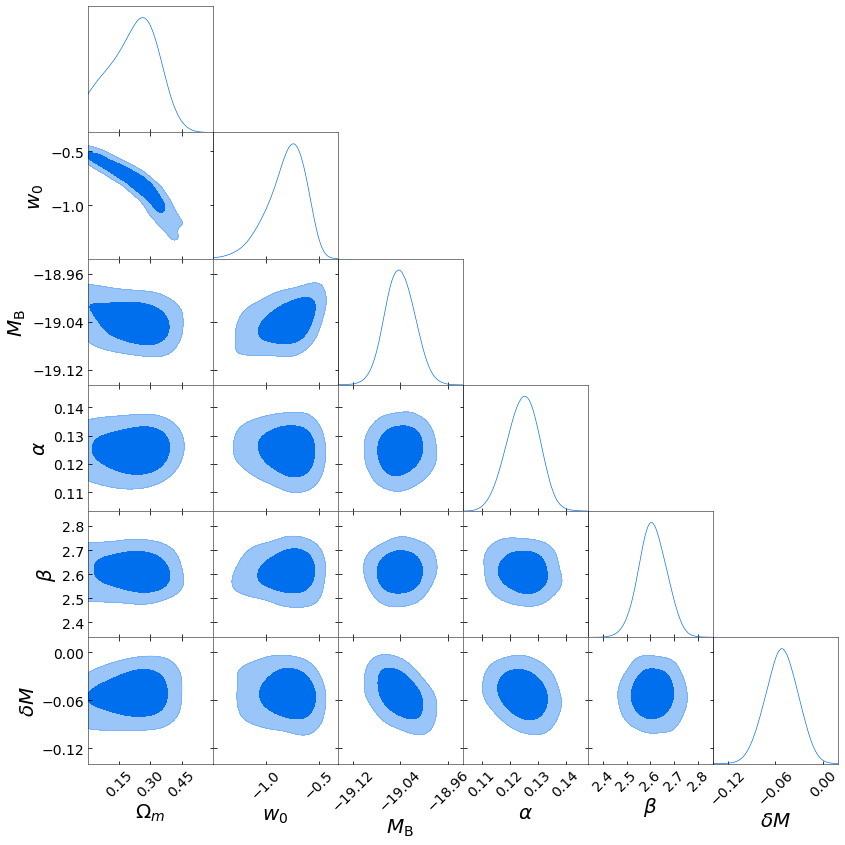

Saving simulators/jla_supernovae/results/mafseq_train_loss.pdf


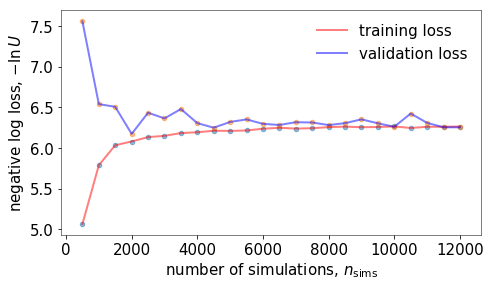

In [14]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
Delfi.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args)

In [15]:
# MDN version
MDN = ndes.MixtureDensityNetwork(n_inputs=6, n_outputs=6, n_components=3, n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
Delfi = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                       results_dir = "simulators/jla_supernovae/results/mdn")

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 13.6099, Val_loss: 13.7261
Epoch 00001, Train_loss: 11.2063, Val_loss: 11.3224
Epoch 00002, Train_loss: 10.1133, Val_loss: 10.2200
Epoch 00003, Train_loss: 9.2981, Val_loss: 9.3988
Epoch 00004, Train_loss: 8.6292, Val_loss: 8.7339
Epoch 00005, Train_loss: 8.1103, Val_loss: 8.2049
Epoch 00006, Train_loss: 7.7445, Val_loss: 7.8367
Epoch 00007, Train_loss: 7.4908, Val_loss: 7.5697
Epoch 00008, Train_loss: 7.3031, Val_loss: 7.3838
Epoch 00009, Train_loss: 7.1734, Val_loss: 7.2565
Epoch 00010, Train_loss: 7.0607, Val_loss: 7.1373
Epoch 00011, Train_loss: 6.9725, Val_loss: 7.0558
Epoch 00012, Train_loss: 6.9082, Val_loss: 6.9815
Epoch 00013, Train_loss: 6.8702, Val_loss: 6.9381
Epoch 00014, Train_loss: 6.8136, Val_loss: 6.8923
Epoch 00015, Train_loss: 6.7847, Val_loss: 6.8578
Epoch 00016, Train_loss: 6.7800, Val_loss: 6.8444
Epoch 00017, Train_loss: 6.8432, Val_loss: 6.9188
Epoch 00018, T

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Done.
Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Saving simulators/jla_supernovae/results/mdnfisher_pretrain_post.pdf


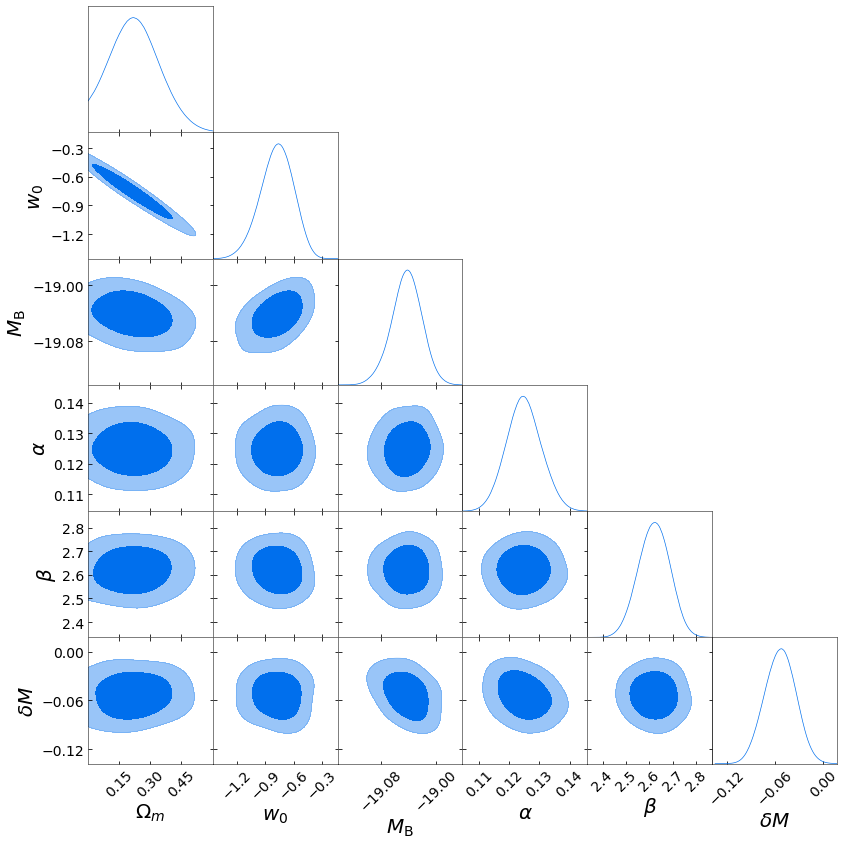

In [16]:
# Do the Fisher pre-training
Delfi.fisher_pretraining(50000, prior, epochs=100, patience=20)

Running initial 500 sims...
Done.
Epoch 00000, Train_loss: 8.3046, Val_loss: 7.5608
Epoch 00001, Train_loss: 7.6683, Val_loss: 7.1608
Epoch 00002, Train_loss: 7.3112, Val_loss: 6.8231
Epoch 00003, Train_loss: 7.1669, Val_loss: 6.7359
Epoch 00004, Train_loss: 7.0640, Val_loss: 6.6870
Epoch 00005, Train_loss: 7.0059, Val_loss: 6.6614
Epoch 00006, Train_loss: 6.9617, Val_loss: 6.6706
Epoch 00007, Train_loss: 6.9175, Val_loss: 6.6294
Epoch 00008, Train_loss: 6.8829, Val_loss: 6.5876
Epoch 00009, Train_loss: 6.8589, Val_loss: 6.6259
Epoch 00010, Train_loss: 6.8269, Val_loss: 6.5604
Epoch 00011, Train_loss: 6.7939, Val_loss: 6.5927
Epoch 00012, Train_loss: 6.7641, Val_loss: 6.5638
Epoch 00013, Train_loss: 6.7368, Val_loss: 6.5486
Epoch 00014, Train_loss: 6.7031, Val_loss: 6.5183
Epoch 00015, Train_loss: 6.6786, Val_loss: 6.4865
Epoch 00016, Train_loss: 6.6494, Val_loss: 6.4719
Epoch 00017, Train_loss: 6.6215, Val_loss: 6.4540
Epoch 00018, Train_loss: 6.5949, Val_loss: 6.4648
Epoch 00019, Tra

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_0.pdf


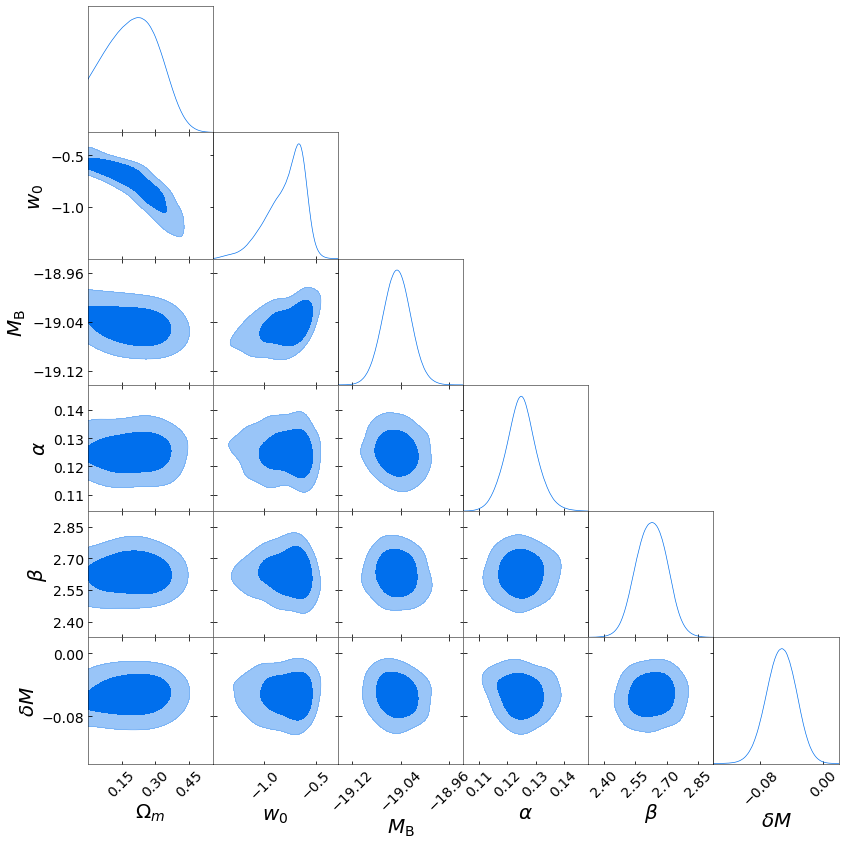

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3209, Val_loss: 6.3880
Epoch 00001, Train_loss: 6.2898, Val_loss: 6.3578
Epoch 00002, Train_loss: 6.2778, Val_loss: 6.3699
Epoch 00003, Train_loss: 6.2659, Val_loss: 6.3514
Epoch 00004, Train_loss: 6.2537, Val_loss: 6.3615
Epoch 00005, Train_loss: 6.2464, Val_loss: 6.3487
Epoch 00006, Train_loss: 6.2422, Val_loss: 6.3561
Epoch 00007, Train_loss: 6.2434, Val_loss: 6.3672
Epoch 00008, Train_loss: 6.2337, Val_loss: 6.3376
Epoch 00009, Train_loss: 6.2267, Val_loss: 6.3545
Epoch 00010, Train_loss: 6.2279, Val_loss: 6.3397
Epoch 00011, Train_loss: 6.2221, Val_loss: 6.3540
Epoch 00012, Train_loss: 6.2160, Val_loss: 6.3396
Epoch 00013, Train_loss: 6.2135, Val_loss: 6.3446
Epoch 00014, Train_loss: 6.2113, Val_loss: 6.3300
Epoch 00015, Train_loss: 6.2125, Val_loss: 6.3537
Epoch 00016, Train_loss: 6.2045, Val_loss: 6.3376
Epoch 00017, Train_loss: 6.2026, Val_loss: 6.3360
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_1.pdf


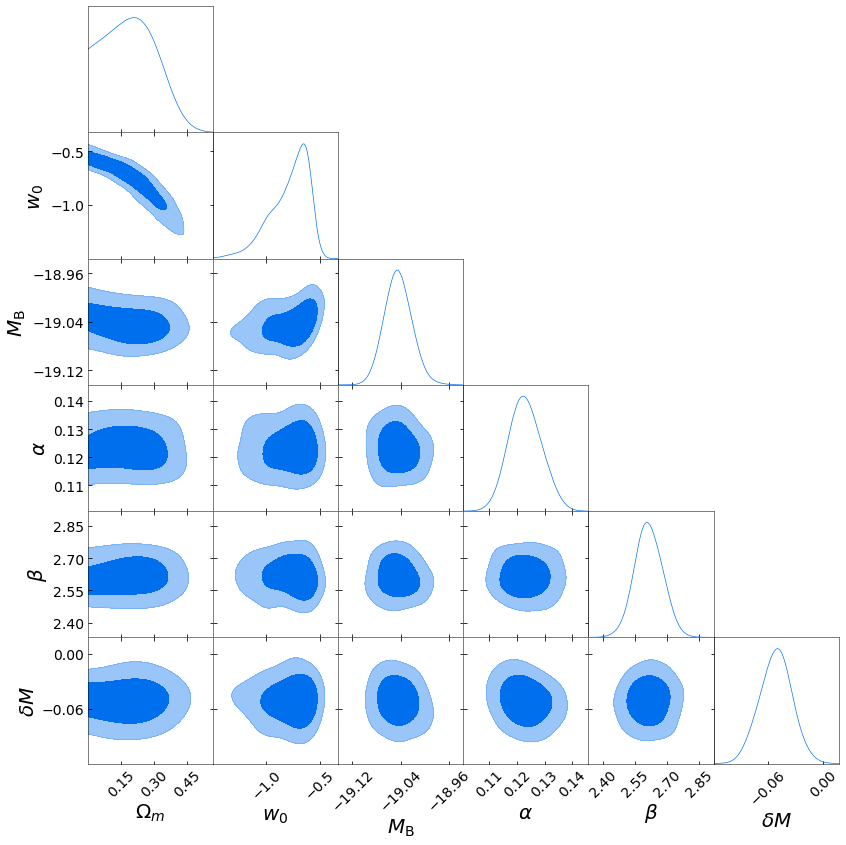

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


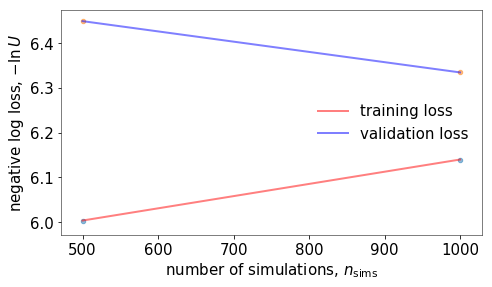

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2610, Val_loss: 6.4080
Epoch 00001, Train_loss: 6.2488, Val_loss: 6.3979
Epoch 00002, Train_loss: 6.2314, Val_loss: 6.4104
Epoch 00003, Train_loss: 6.2288, Val_loss: 6.4201
Epoch 00004, Train_loss: 6.2237, Val_loss: 6.4235
Epoch 00005, Train_loss: 6.2243, Val_loss: 6.4394
Epoch 00006, Train_loss: 6.2144, Val_loss: 6.4316
Epoch 00007, Train_loss: 6.2111, Val_loss: 6.4317
Epoch 00008, Train_loss: 6.2078, Val_loss: 6.4273
Epoch 00009, Train_loss: 6.2046, Val_loss: 6.4332
Epoch 00010, Train_loss: 6.2056, Val_loss: 6.4555
Epoch 00011, Train_loss: 6.2063, Val_loss: 6.4378
Epoch 00012, Train_loss: 6.2006, Val_loss: 6.4295
Epoch 00013, Train_loss: 6.1981, Val_loss: 6.4604
Epoch 00014, Train_loss: 6.1984, Val_loss: 6.4576
Epoch 00015, Train_loss: 6.1965, Val_loss: 6.4408
Epoch 00016, Train_loss: 6.1924, Val_loss: 6.4527
Epoch 00017, Train_loss: 6.1929, Val_loss: 6.4659
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_2.pdf


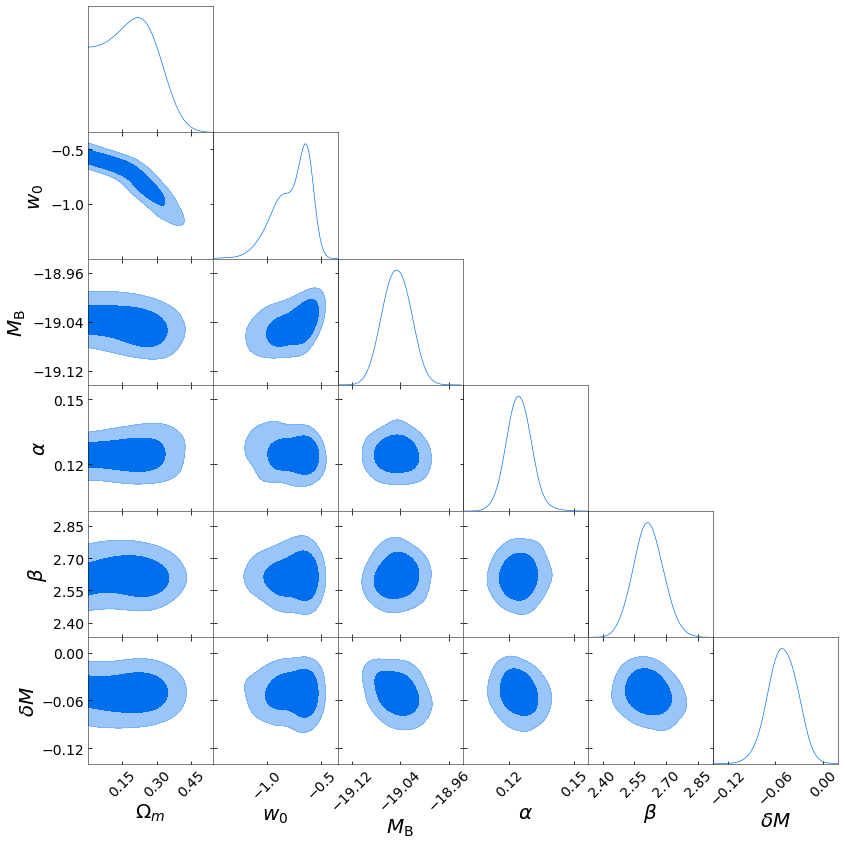

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


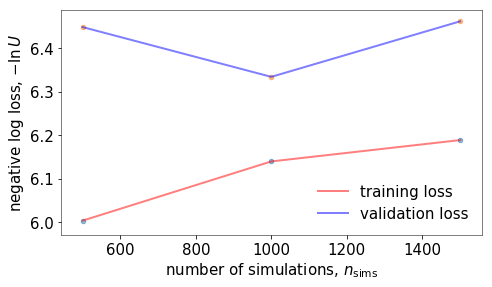

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3233, Val_loss: 6.1735
Epoch 00001, Train_loss: 6.3038, Val_loss: 6.1570
Epoch 00002, Train_loss: 6.2911, Val_loss: 6.1644
Epoch 00003, Train_loss: 6.2875, Val_loss: 6.1840
Epoch 00004, Train_loss: 6.2766, Val_loss: 6.1652
Epoch 00005, Train_loss: 6.2715, Val_loss: 6.1739
Epoch 00006, Train_loss: 6.2691, Val_loss: 6.1733
Epoch 00007, Train_loss: 6.2705, Val_loss: 6.1706
Epoch 00008, Train_loss: 6.2675, Val_loss: 6.1863
Epoch 00009, Train_loss: 6.2576, Val_loss: 6.1715
Epoch 00010, Train_loss: 6.2586, Val_loss: 6.1799
Epoch 00011, Train_loss: 6.2526, Val_loss: 6.1739
Epoch 00012, Train_loss: 6.2487, Val_loss: 6.1768
Epoch 00013, Train_loss: 6.2500, Val_loss: 6.1828
Epoch 00014, Train_loss: 6.2496, Val_loss: 6.1596
Epoch 00015, Train_loss: 6.2422, Val_loss: 6.1798
Epoch 00016, Train_loss: 6.2405, Val_loss: 6.1607
Epoch 00017, Train_loss: 6.2393, Val_loss: 6.1671
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_3.pdf


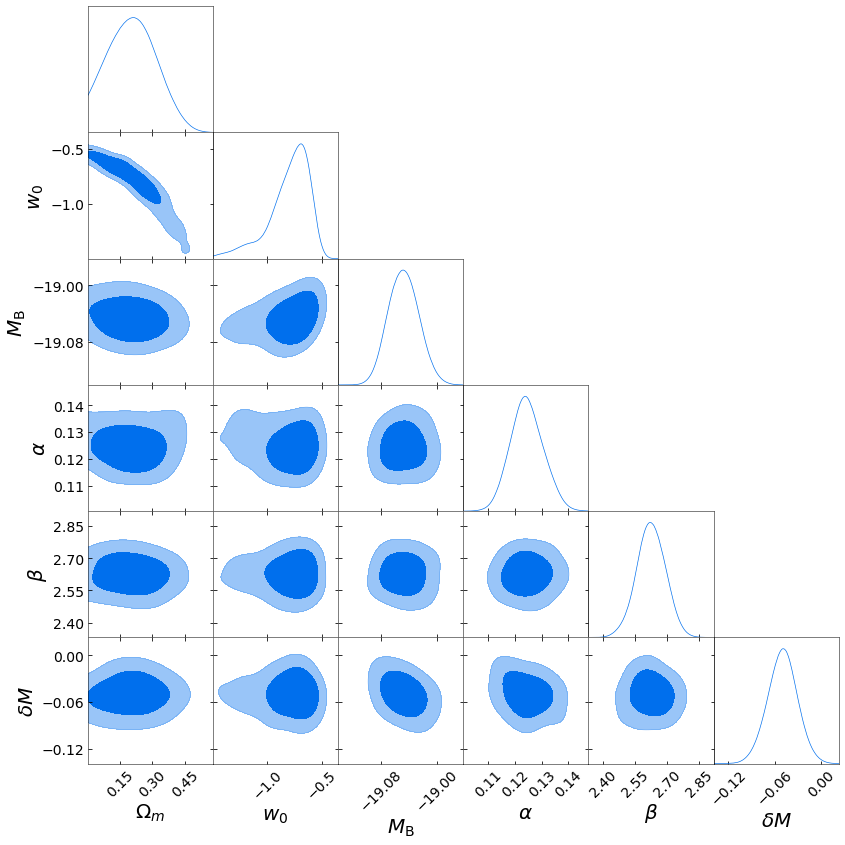

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


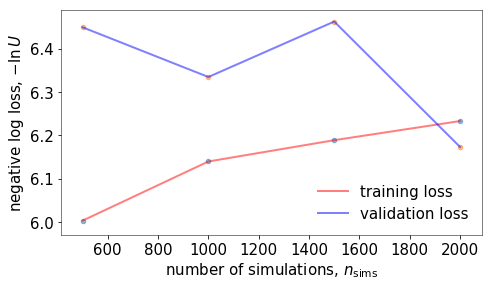

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2974, Val_loss: 6.3281
Epoch 00001, Train_loss: 6.2872, Val_loss: 6.3284
Epoch 00002, Train_loss: 6.2826, Val_loss: 6.3289
Epoch 00003, Train_loss: 6.2709, Val_loss: 6.3301
Epoch 00004, Train_loss: 6.2660, Val_loss: 6.3322
Epoch 00005, Train_loss: 6.2635, Val_loss: 6.3332
Epoch 00006, Train_loss: 6.2601, Val_loss: 6.3306
Epoch 00007, Train_loss: 6.2543, Val_loss: 6.3248
Epoch 00008, Train_loss: 6.2504, Val_loss: 6.3308
Epoch 00009, Train_loss: 6.2464, Val_loss: 6.3224
Epoch 00010, Train_loss: 6.2448, Val_loss: 6.3198
Epoch 00011, Train_loss: 6.2427, Val_loss: 6.3215
Epoch 00012, Train_loss: 6.2381, Val_loss: 6.3165
Epoch 00013, Train_loss: 6.2387, Val_loss: 6.3230
Epoch 00014, Train_loss: 6.2343, Val_loss: 6.3213
Epoch 00015, Train_loss: 6.2344, Val_loss: 6.3150
Epoch 00016, Train_loss: 6.2334, Val_loss: 6.3290
Epoch 00017, Train_loss: 6.2330, Val_loss: 6.3050
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_4.pdf


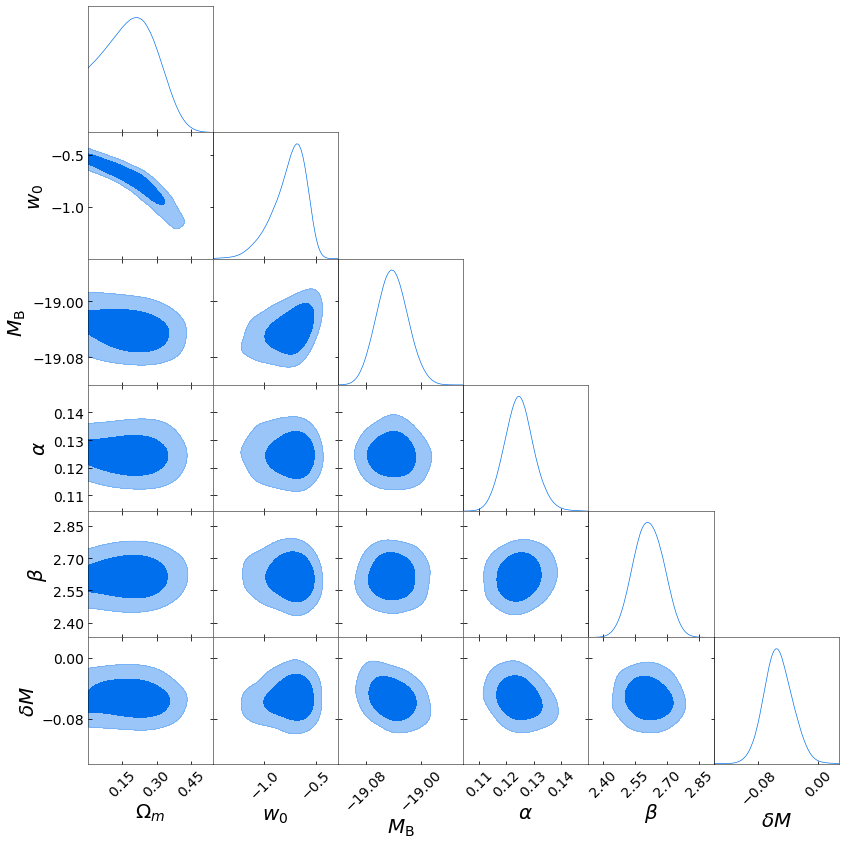

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


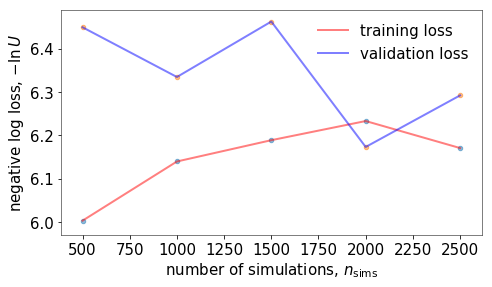

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2175, Val_loss: 6.2324
Epoch 00001, Train_loss: 6.2069, Val_loss: 6.2376
Epoch 00002, Train_loss: 6.2034, Val_loss: 6.2400
Epoch 00003, Train_loss: 6.2039, Val_loss: 6.2446
Epoch 00004, Train_loss: 6.2006, Val_loss: 6.2445
Epoch 00005, Train_loss: 6.2019, Val_loss: 6.2499
Epoch 00006, Train_loss: 6.1970, Val_loss: 6.2490
Epoch 00007, Train_loss: 6.1960, Val_loss: 6.2458
Epoch 00008, Train_loss: 6.1942, Val_loss: 6.2489
Epoch 00009, Train_loss: 6.1932, Val_loss: 6.2528
Epoch 00010, Train_loss: 6.1925, Val_loss: 6.2551
Epoch 00011, Train_loss: 6.1957, Val_loss: 6.2635
Epoch 00012, Train_loss: 6.1907, Val_loss: 6.2516
Epoch 00013, Train_loss: 6.1893, Val_loss: 6.2590
Epoch 00014, Train_loss: 6.1879, Val_loss: 6.2535
Epoch 00015, Train_loss: 6.1886, Val_loss: 6.2612
Epoch 00016, Train_loss: 6.1899, Val_loss: 6.2547
Epoch 00017, Train_loss: 6.1952, Val_loss: 6.2707
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_5.pdf


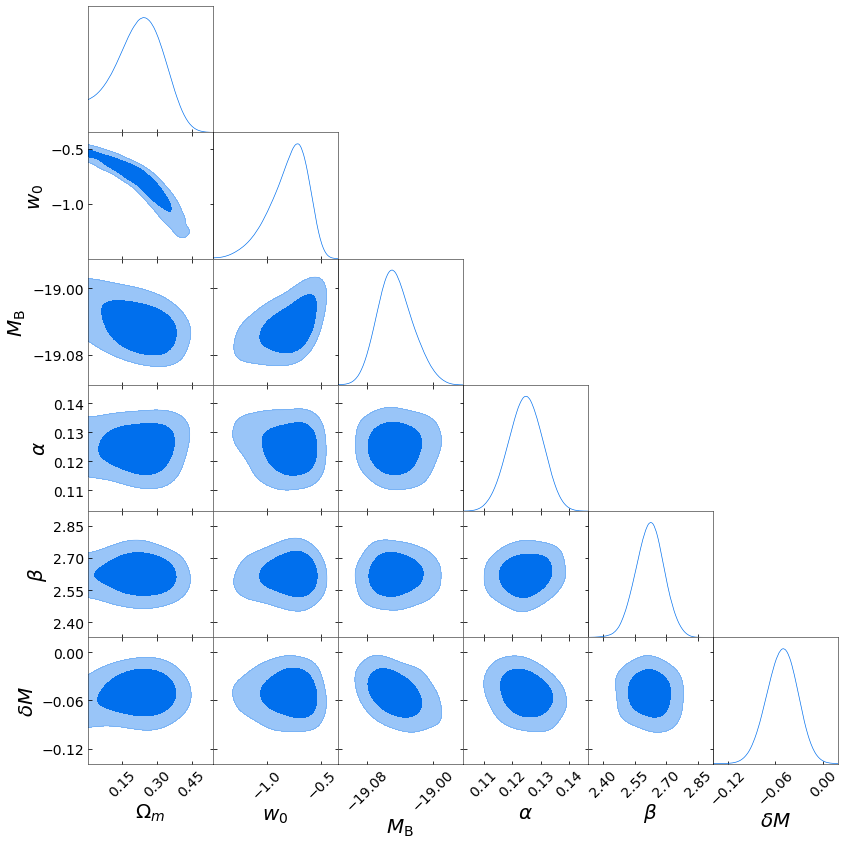

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


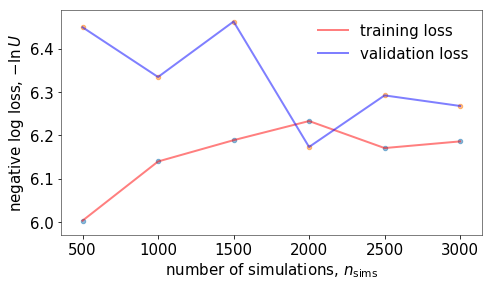

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2412, Val_loss: 6.1786
Epoch 00001, Train_loss: 6.2361, Val_loss: 6.1918
Epoch 00002, Train_loss: 6.2338, Val_loss: 6.1932
Epoch 00003, Train_loss: 6.2315, Val_loss: 6.1907
Epoch 00004, Train_loss: 6.2303, Val_loss: 6.2008
Epoch 00005, Train_loss: 6.2285, Val_loss: 6.2034
Epoch 00006, Train_loss: 6.2264, Val_loss: 6.1915
Epoch 00007, Train_loss: 6.2271, Val_loss: 6.1909
Epoch 00008, Train_loss: 6.2254, Val_loss: 6.1974
Epoch 00009, Train_loss: 6.2231, Val_loss: 6.2017
Epoch 00010, Train_loss: 6.2224, Val_loss: 6.1935
Epoch 00011, Train_loss: 6.2214, Val_loss: 6.1936
Epoch 00012, Train_loss: 6.2197, Val_loss: 6.1971
Epoch 00013, Train_loss: 6.2220, Val_loss: 6.2139
Epoch 00014, Train_loss: 6.2181, Val_loss: 6.2024
Epoch 00015, Train_loss: 6.2170, Val_loss: 6.1958
Epoch 00016, Train_loss: 6.2172, Val_loss: 6.1951
Epoch 00017, Train_loss: 6.2163, Val_loss: 6.1969
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_6.pdf


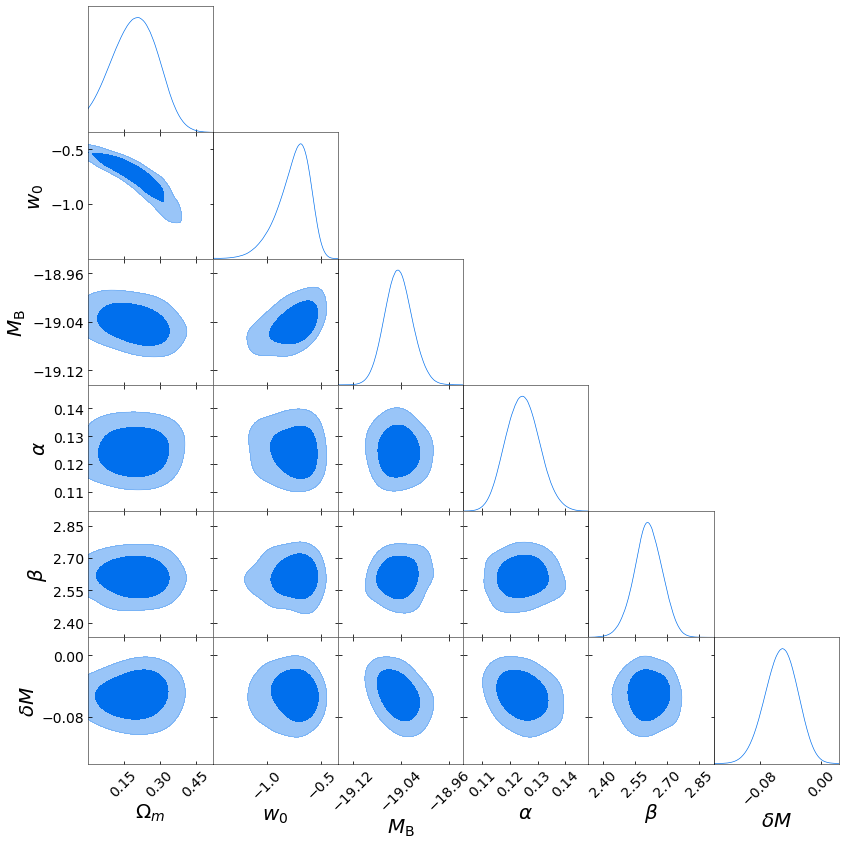

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


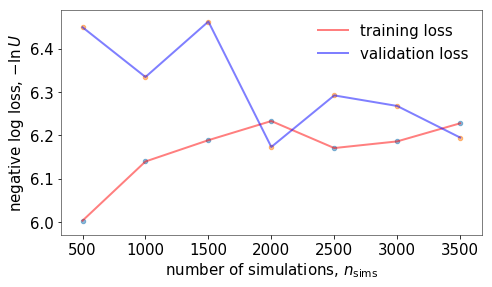

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2505, Val_loss: 6.2046
Epoch 00001, Train_loss: 6.2436, Val_loss: 6.1996
Epoch 00002, Train_loss: 6.2404, Val_loss: 6.2009
Epoch 00003, Train_loss: 6.2379, Val_loss: 6.2031
Epoch 00004, Train_loss: 6.2376, Val_loss: 6.2045
Epoch 00005, Train_loss: 6.2347, Val_loss: 6.2065
Epoch 00006, Train_loss: 6.2341, Val_loss: 6.2057
Epoch 00007, Train_loss: 6.2337, Val_loss: 6.2087
Epoch 00008, Train_loss: 6.2310, Val_loss: 6.2052
Epoch 00009, Train_loss: 6.2316, Val_loss: 6.2106
Epoch 00010, Train_loss: 6.2283, Val_loss: 6.2083
Epoch 00011, Train_loss: 6.2300, Val_loss: 6.2032
Epoch 00012, Train_loss: 6.2306, Val_loss: 6.2092
Epoch 00013, Train_loss: 6.2258, Val_loss: 6.2100
Epoch 00014, Train_loss: 6.2314, Val_loss: 6.2189
Epoch 00015, Train_loss: 6.2258, Val_loss: 6.2085
Epoch 00016, Train_loss: 6.2392, Val_loss: 6.2208
Epoch 00017, Train_loss: 6.2225, Val_loss: 6.2094
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_7.pdf


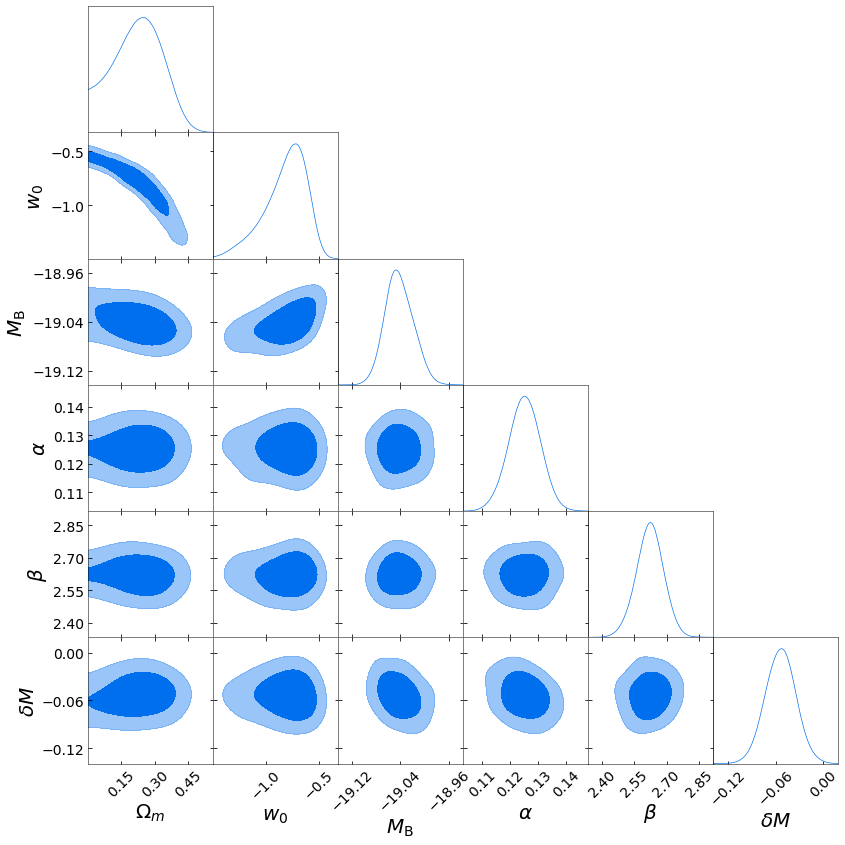

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


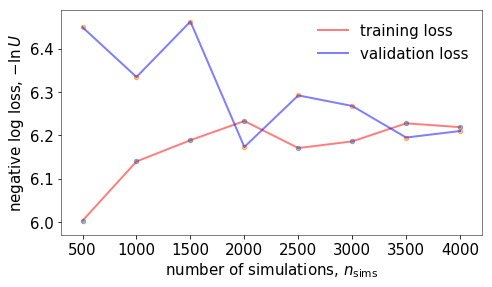

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2510, Val_loss: 6.2152
Epoch 00001, Train_loss: 6.2482, Val_loss: 6.2150
Epoch 00002, Train_loss: 6.2456, Val_loss: 6.2211
Epoch 00003, Train_loss: 6.2424, Val_loss: 6.2227
Epoch 00004, Train_loss: 6.2413, Val_loss: 6.2197
Epoch 00005, Train_loss: 6.2394, Val_loss: 6.2243
Epoch 00006, Train_loss: 6.2378, Val_loss: 6.2208
Epoch 00007, Train_loss: 6.2365, Val_loss: 6.2239
Epoch 00008, Train_loss: 6.2384, Val_loss: 6.2273
Epoch 00009, Train_loss: 6.2347, Val_loss: 6.2262
Epoch 00010, Train_loss: 6.2330, Val_loss: 6.2190
Epoch 00011, Train_loss: 6.2314, Val_loss: 6.2209
Epoch 00012, Train_loss: 6.2302, Val_loss: 6.2243
Epoch 00013, Train_loss: 6.2325, Val_loss: 6.2301
Epoch 00014, Train_loss: 6.2299, Val_loss: 6.2246
Epoch 00015, Train_loss: 6.2287, Val_loss: 6.2241
Epoch 00016, Train_loss: 6.2305, Val_loss: 6.2287
Epoch 00017, Train_loss: 6.2344, Val_loss: 6.2304
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_8.pdf


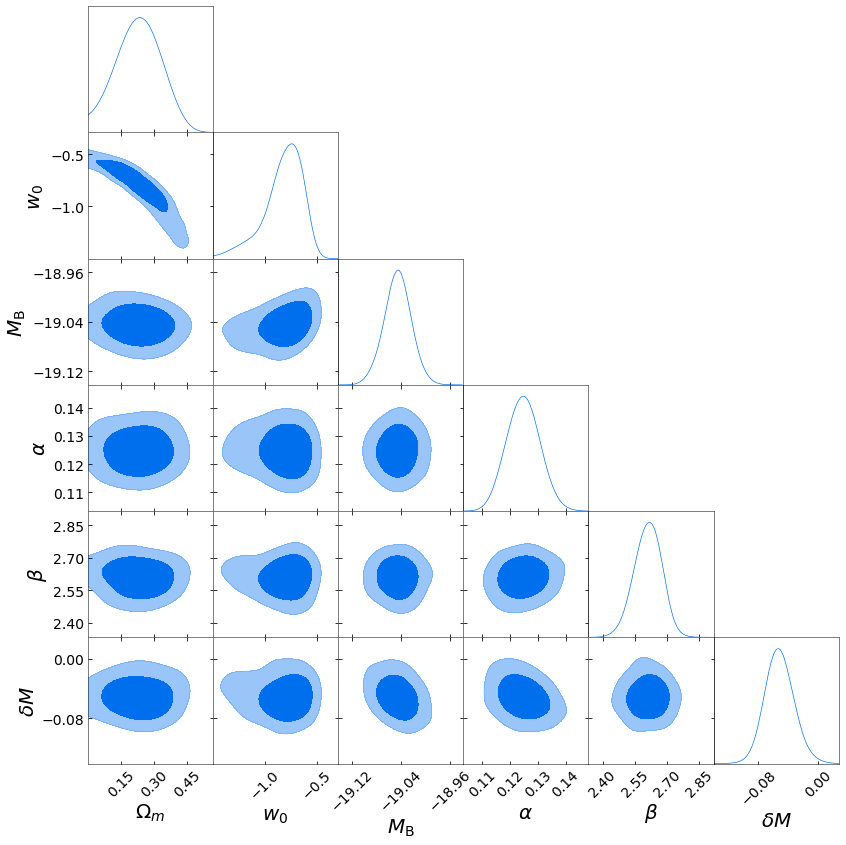

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


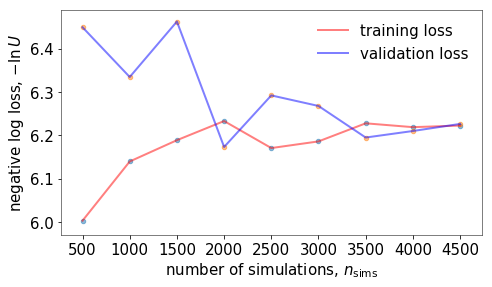

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2661, Val_loss: 6.1717
Epoch 00001, Train_loss: 6.2640, Val_loss: 6.1834
Epoch 00002, Train_loss: 6.2605, Val_loss: 6.1809
Epoch 00003, Train_loss: 6.2577, Val_loss: 6.1802
Epoch 00004, Train_loss: 6.2562, Val_loss: 6.1841
Epoch 00005, Train_loss: 6.2545, Val_loss: 6.1853
Epoch 00006, Train_loss: 6.2533, Val_loss: 6.1850
Epoch 00007, Train_loss: 6.2515, Val_loss: 6.1852
Epoch 00008, Train_loss: 6.2506, Val_loss: 6.1835
Epoch 00009, Train_loss: 6.2501, Val_loss: 6.1876
Epoch 00010, Train_loss: 6.2492, Val_loss: 6.1901
Epoch 00011, Train_loss: 6.2480, Val_loss: 6.1884
Epoch 00012, Train_loss: 6.2467, Val_loss: 6.1879
Epoch 00013, Train_loss: 6.2449, Val_loss: 6.1870
Epoch 00014, Train_loss: 6.2438, Val_loss: 6.1850
Epoch 00015, Train_loss: 6.2459, Val_loss: 6.1917
Epoch 00016, Train_loss: 6.2433, Val_loss: 6.1924
Epoch 00017, Train_loss: 6.2413, Val_loss: 6.1869
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_9.pdf


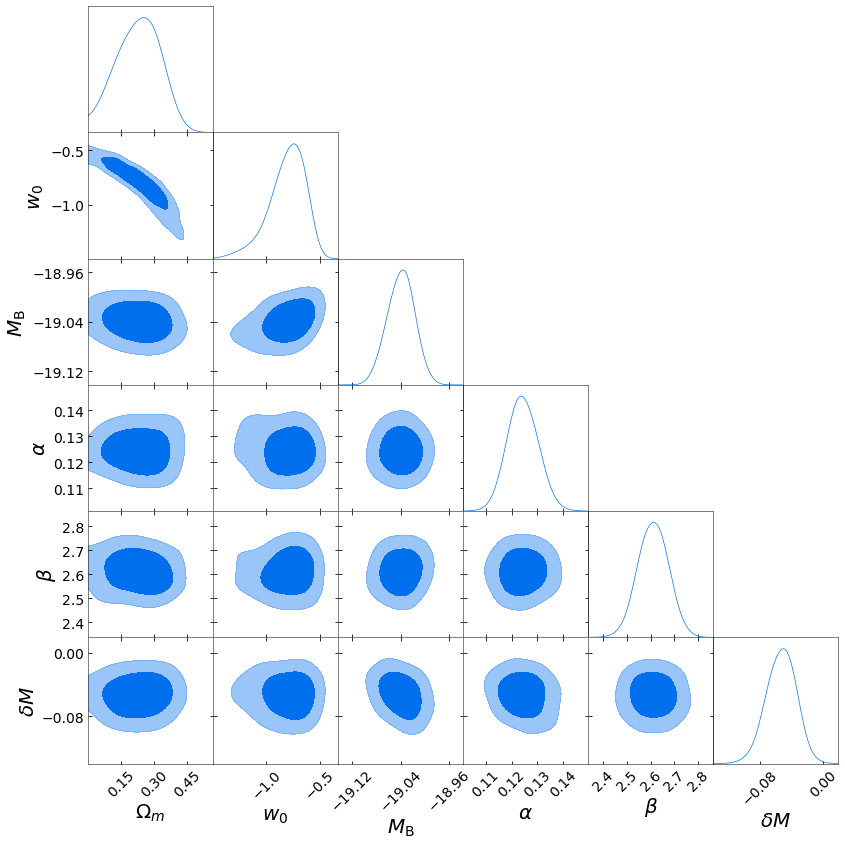

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


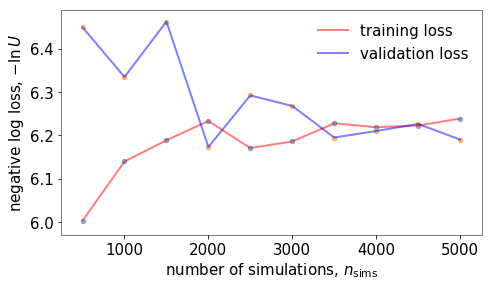

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2809, Val_loss: 6.2246
Epoch 00001, Train_loss: 6.2747, Val_loss: 6.2341
Epoch 00002, Train_loss: 6.2718, Val_loss: 6.2324
Epoch 00003, Train_loss: 6.2705, Val_loss: 6.2338
Epoch 00004, Train_loss: 6.2666, Val_loss: 6.2376
Epoch 00005, Train_loss: 6.2655, Val_loss: 6.2407
Epoch 00006, Train_loss: 6.2640, Val_loss: 6.2375
Epoch 00007, Train_loss: 6.2630, Val_loss: 6.2387
Epoch 00008, Train_loss: 6.2607, Val_loss: 6.2417
Epoch 00009, Train_loss: 6.2625, Val_loss: 6.2454
Epoch 00010, Train_loss: 6.2576, Val_loss: 6.2411
Epoch 00011, Train_loss: 6.2573, Val_loss: 6.2434
Epoch 00012, Train_loss: 6.2568, Val_loss: 6.2447
Epoch 00013, Train_loss: 6.2574, Val_loss: 6.2400
Epoch 00014, Train_loss: 6.2609, Val_loss: 6.2389
Epoch 00015, Train_loss: 6.2528, Val_loss: 6.2432
Epoch 00016, Train_loss: 6.2565, Val_loss: 6.2528
Epoch 00017, Train_loss: 6.2537, Val_loss: 6.2465
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_10.pdf


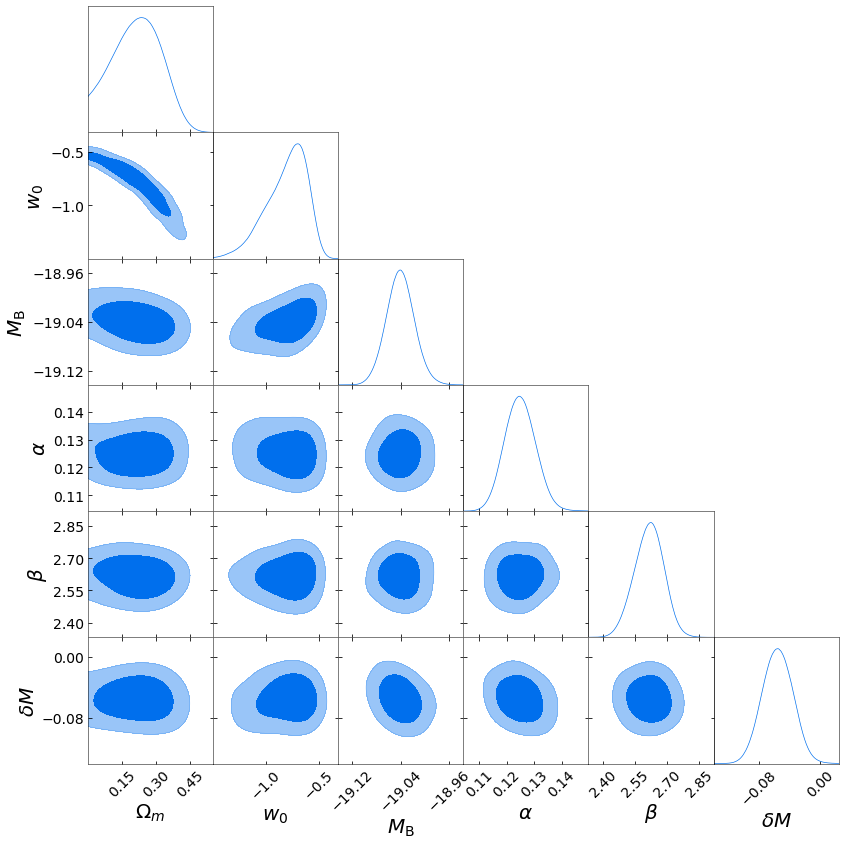

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


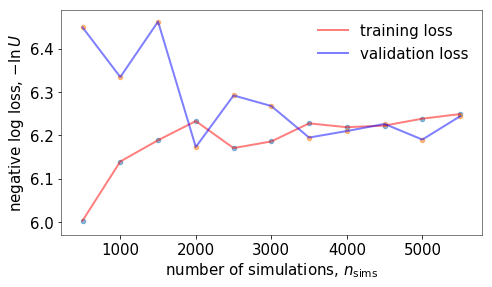

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2887, Val_loss: 6.2296
Epoch 00001, Train_loss: 6.2849, Val_loss: 6.2355
Epoch 00002, Train_loss: 6.2826, Val_loss: 6.2385
Epoch 00003, Train_loss: 6.2804, Val_loss: 6.2376
Epoch 00004, Train_loss: 6.2783, Val_loss: 6.2373
Epoch 00005, Train_loss: 6.2774, Val_loss: 6.2379
Epoch 00006, Train_loss: 6.2763, Val_loss: 6.2416
Epoch 00007, Train_loss: 6.2744, Val_loss: 6.2375
Epoch 00008, Train_loss: 6.2740, Val_loss: 6.2377
Epoch 00009, Train_loss: 6.2719, Val_loss: 6.2399
Epoch 00010, Train_loss: 6.2706, Val_loss: 6.2368
Epoch 00011, Train_loss: 6.2695, Val_loss: 6.2401
Epoch 00012, Train_loss: 6.2699, Val_loss: 6.2398
Epoch 00013, Train_loss: 6.2696, Val_loss: 6.2376
Epoch 00014, Train_loss: 6.2672, Val_loss: 6.2390
Epoch 00015, Train_loss: 6.2651, Val_loss: 6.2373
Epoch 00016, Train_loss: 6.2645, Val_loss: 6.2395
Epoch 00017, Train_loss: 6.2637, Val_loss: 6.2360
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_11.pdf


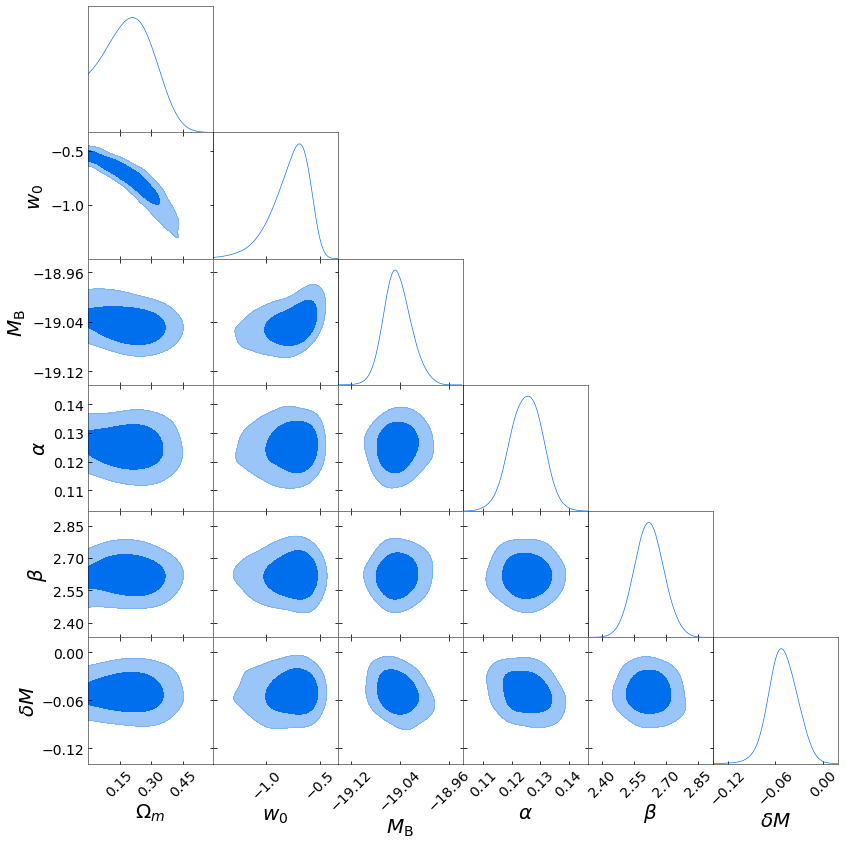

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


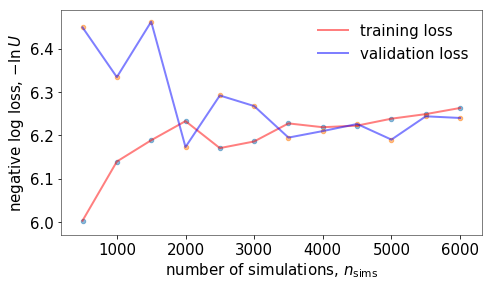

Population 12/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2927, Val_loss: 6.4021
Epoch 00001, Train_loss: 6.2891, Val_loss: 6.4051
Epoch 00002, Train_loss: 6.2853, Val_loss: 6.4040
Epoch 00003, Train_loss: 6.2841, Val_loss: 6.4091
Epoch 00004, Train_loss: 6.2821, Val_loss: 6.4062
Epoch 00005, Train_loss: 6.2832, Val_loss: 6.4081
Epoch 00006, Train_loss: 6.2802, Val_loss: 6.4099
Epoch 00007, Train_loss: 6.2762, Val_loss: 6.4064
Epoch 00008, Train_loss: 6.2754, Val_loss: 6.4060
Epoch 00009, Train_loss: 6.2739, Val_loss: 6.4049
Epoch 00010, Train_loss: 6.2739, Val_loss: 6.4089
Epoch 00011, Train_loss: 6.2712, Val_loss: 6.4056
Epoch 00012, Train_loss: 6.2720, Val_loss: 6.4078
Epoch 00013, Train_loss: 6.2691, Val_loss: 6.4046
Epoch 00014, Train_loss: 6.2675, Val_loss: 6.4080
Epoch 00015, Train_loss: 6.2668, Val_loss: 6.4069
Epoch 00016, Train_loss: 6.2660, Val_loss: 6.4052
Epoch 00017, Train_loss: 6.2650, Val_loss: 6.4046
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_12.pdf


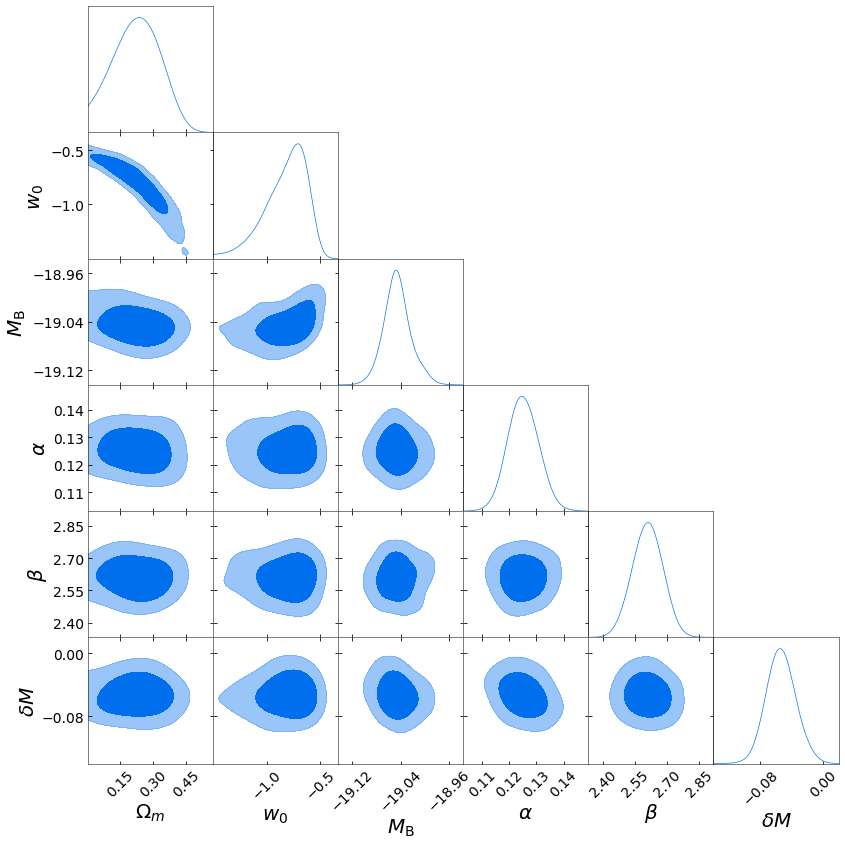

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


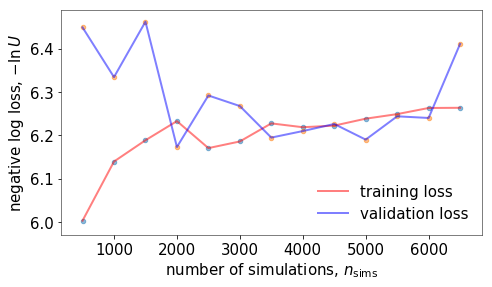

Population 13/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3125, Val_loss: 6.2390
Epoch 00001, Train_loss: 6.3090, Val_loss: 6.2386
Epoch 00002, Train_loss: 6.3066, Val_loss: 6.2416
Epoch 00003, Train_loss: 6.3042, Val_loss: 6.2418
Epoch 00004, Train_loss: 6.3024, Val_loss: 6.2420
Epoch 00005, Train_loss: 6.3008, Val_loss: 6.2403
Epoch 00006, Train_loss: 6.2991, Val_loss: 6.2415
Epoch 00007, Train_loss: 6.2976, Val_loss: 6.2422
Epoch 00008, Train_loss: 6.2973, Val_loss: 6.2449
Epoch 00009, Train_loss: 6.2950, Val_loss: 6.2403
Epoch 00010, Train_loss: 6.2949, Val_loss: 6.2417
Epoch 00011, Train_loss: 6.2940, Val_loss: 6.2478
Epoch 00012, Train_loss: 6.2958, Val_loss: 6.2490
Epoch 00013, Train_loss: 6.2922, Val_loss: 6.2463
Epoch 00014, Train_loss: 6.2892, Val_loss: 6.2438
Epoch 00015, Train_loss: 6.2933, Val_loss: 6.2409
Epoch 00016, Train_loss: 6.2882, Val_loss: 6.2404
Epoch 00017, Train_loss: 6.2870, Val_loss: 6.2440
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_13.pdf


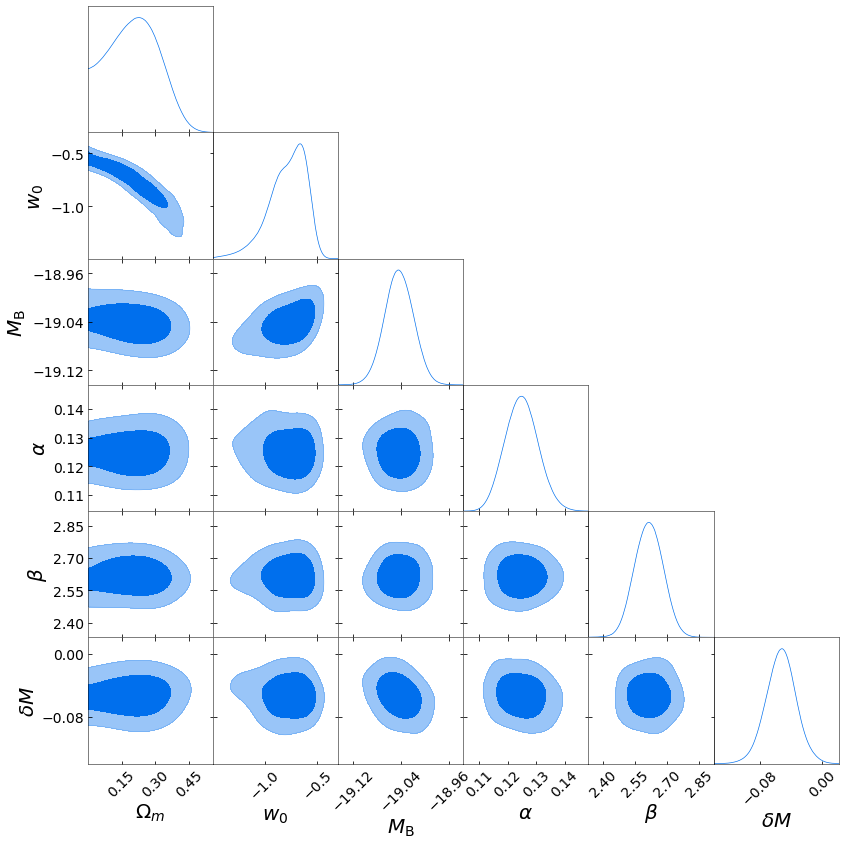

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


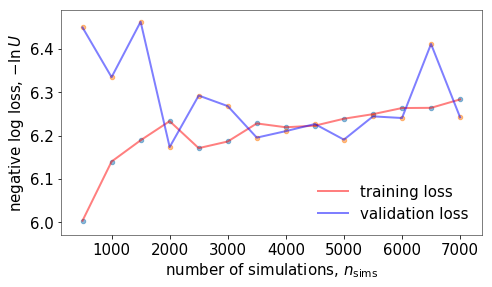

Population 14/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3167, Val_loss: 6.2254
Epoch 00001, Train_loss: 6.3137, Val_loss: 6.2305
Epoch 00002, Train_loss: 6.3163, Val_loss: 6.2373
Epoch 00003, Train_loss: 6.3100, Val_loss: 6.2318
Epoch 00004, Train_loss: 6.3081, Val_loss: 6.2329
Epoch 00005, Train_loss: 6.3087, Val_loss: 6.2404
Epoch 00006, Train_loss: 6.3066, Val_loss: 6.2354
Epoch 00007, Train_loss: 6.3075, Val_loss: 6.2358
Epoch 00008, Train_loss: 6.3028, Val_loss: 6.2344
Epoch 00009, Train_loss: 6.3009, Val_loss: 6.2337
Epoch 00010, Train_loss: 6.3011, Val_loss: 6.2363
Epoch 00011, Train_loss: 6.2989, Val_loss: 6.2353
Epoch 00012, Train_loss: 6.3009, Val_loss: 6.2333
Epoch 00013, Train_loss: 6.2969, Val_loss: 6.2322
Epoch 00014, Train_loss: 6.2974, Val_loss: 6.2372
Epoch 00015, Train_loss: 6.2954, Val_loss: 6.2353
Epoch 00016, Train_loss: 6.2946, Val_loss: 6.2325
Epoch 00017, Train_loss: 6.2946, Val_loss: 6.2337
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_14.pdf


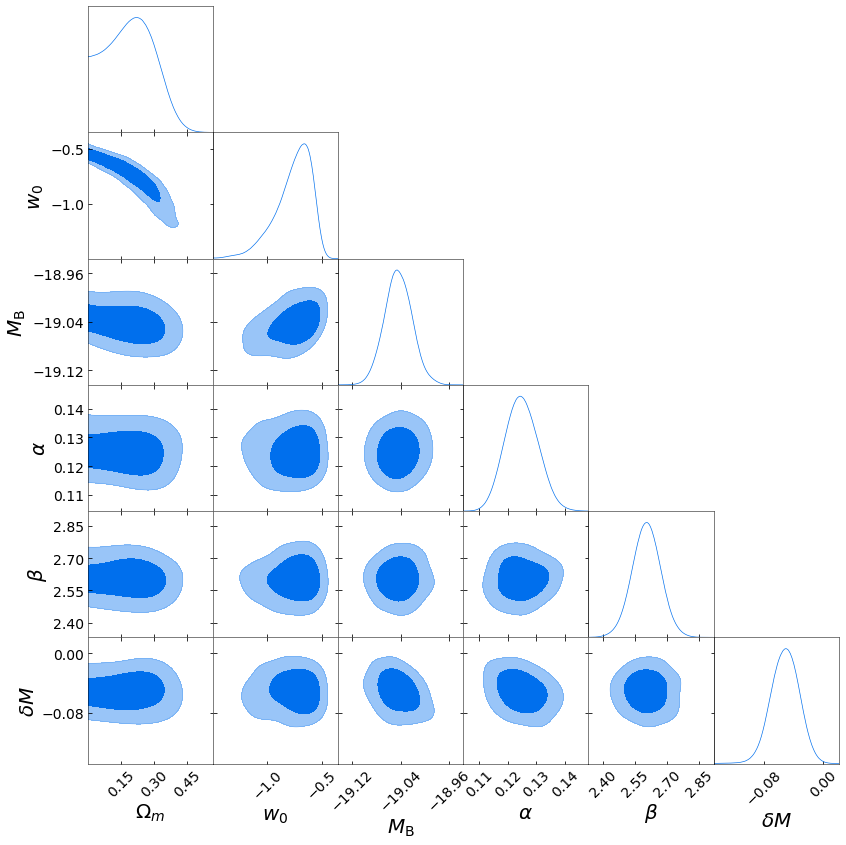

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


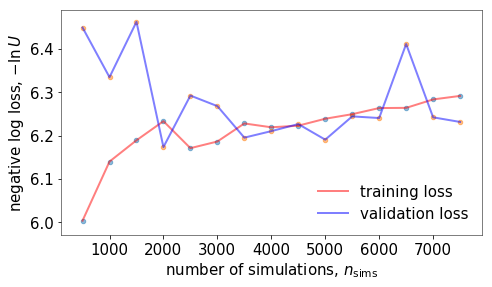

Population 15/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3201, Val_loss: 6.2863
Epoch 00001, Train_loss: 6.3174, Val_loss: 6.2902
Epoch 00002, Train_loss: 6.3153, Val_loss: 6.2912
Epoch 00003, Train_loss: 6.3172, Val_loss: 6.2905
Epoch 00004, Train_loss: 6.3158, Val_loss: 6.2904
Epoch 00005, Train_loss: 6.3110, Val_loss: 6.2914
Epoch 00006, Train_loss: 6.3105, Val_loss: 6.2952
Epoch 00007, Train_loss: 6.3081, Val_loss: 6.2907
Epoch 00008, Train_loss: 6.3079, Val_loss: 6.2927
Epoch 00009, Train_loss: 6.3059, Val_loss: 6.2890
Epoch 00010, Train_loss: 6.3054, Val_loss: 6.2892
Epoch 00011, Train_loss: 6.3055, Val_loss: 6.2925
Epoch 00012, Train_loss: 6.3029, Val_loss: 6.2910
Epoch 00013, Train_loss: 6.3021, Val_loss: 6.2889
Epoch 00014, Train_loss: 6.3024, Val_loss: 6.2867
Epoch 00015, Train_loss: 6.3012, Val_loss: 6.2856
Epoch 00016, Train_loss: 6.3012, Val_loss: 6.2937
Epoch 00017, Train_loss: 6.3014, Val_loss: 6.2920
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_15.pdf


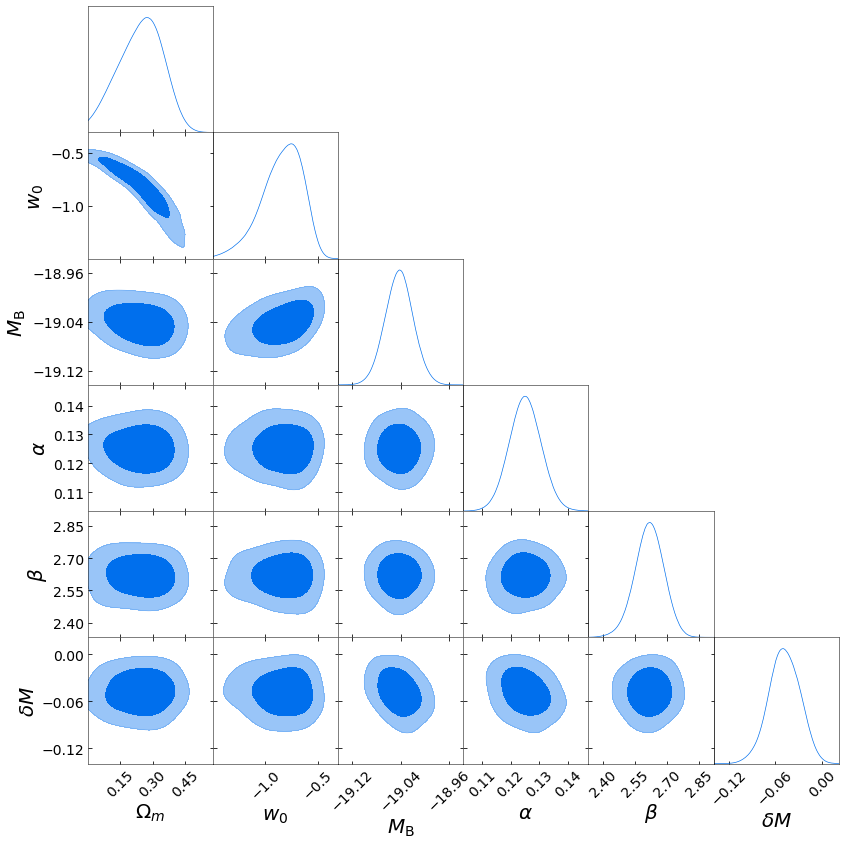

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


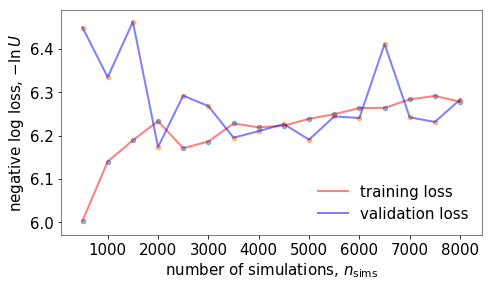

Population 16/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2830, Val_loss: 6.2419
Epoch 00001, Train_loss: 6.2841, Val_loss: 6.2457
Epoch 00002, Train_loss: 6.2823, Val_loss: 6.2455
Epoch 00003, Train_loss: 6.2815, Val_loss: 6.2485
Epoch 00004, Train_loss: 6.2815, Val_loss: 6.2483
Epoch 00005, Train_loss: 6.2806, Val_loss: 6.2511
Epoch 00006, Train_loss: 6.2799, Val_loss: 6.2491
Epoch 00007, Train_loss: 6.2801, Val_loss: 6.2513
Epoch 00008, Train_loss: 6.2791, Val_loss: 6.2505
Epoch 00009, Train_loss: 6.2822, Val_loss: 6.2563
Epoch 00010, Train_loss: 6.2787, Val_loss: 6.2527
Epoch 00011, Train_loss: 6.2805, Val_loss: 6.2536
Epoch 00012, Train_loss: 6.2798, Val_loss: 6.2527
Epoch 00013, Train_loss: 6.2781, Val_loss: 6.2567
Epoch 00014, Train_loss: 6.2837, Val_loss: 6.2592
Epoch 00015, Train_loss: 6.2789, Val_loss: 6.2584
Epoch 00016, Train_loss: 6.2797, Val_loss: 6.2551
Epoch 00017, Train_loss: 6.2773, Val_loss: 6.2535
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_16.pdf


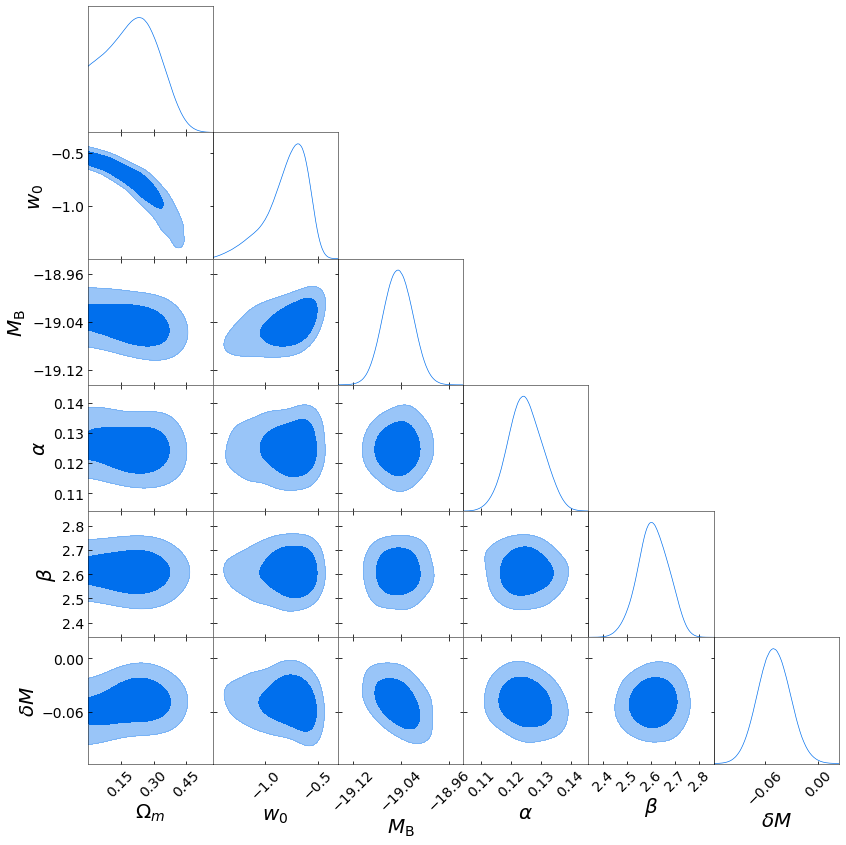

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


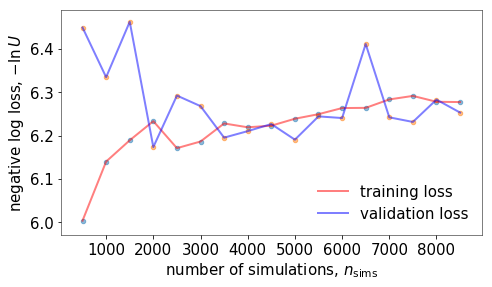

Population 17/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2715, Val_loss: 6.3485
Epoch 00001, Train_loss: 6.2719, Val_loss: 6.3602
Epoch 00002, Train_loss: 6.2707, Val_loss: 6.3526
Epoch 00003, Train_loss: 6.2702, Val_loss: 6.3627
Epoch 00004, Train_loss: 6.2690, Val_loss: 6.3588
Epoch 00005, Train_loss: 6.2688, Val_loss: 6.3617
Epoch 00006, Train_loss: 6.2706, Val_loss: 6.3617
Epoch 00007, Train_loss: 6.2703, Val_loss: 6.3603
Epoch 00008, Train_loss: 6.2686, Val_loss: 6.3590
Epoch 00009, Train_loss: 6.2668, Val_loss: 6.3626
Epoch 00010, Train_loss: 6.2670, Val_loss: 6.3612
Epoch 00011, Train_loss: 6.2662, Val_loss: 6.3613
Epoch 00012, Train_loss: 6.2666, Val_loss: 6.3608
Epoch 00013, Train_loss: 6.2703, Val_loss: 6.3759
Epoch 00014, Train_loss: 6.2665, Val_loss: 6.3604
Epoch 00015, Train_loss: 6.2656, Val_loss: 6.3688
Epoch 00016, Train_loss: 6.2664, Val_loss: 6.3654
Epoch 00017, Train_loss: 6.2655, Val_loss: 6.3628
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_17.pdf


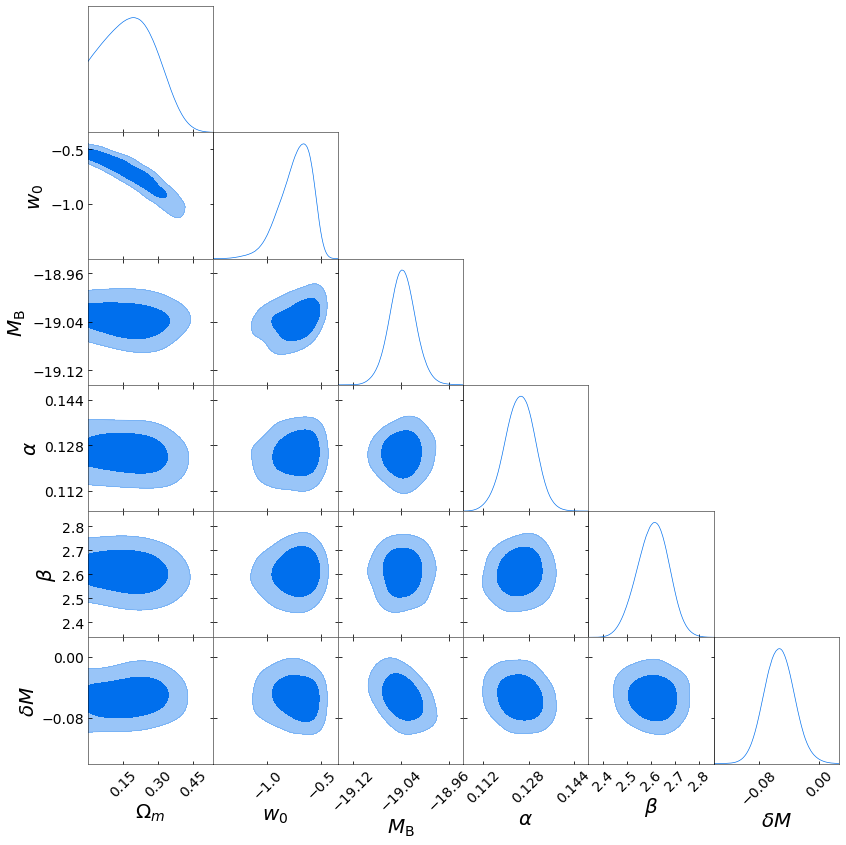

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


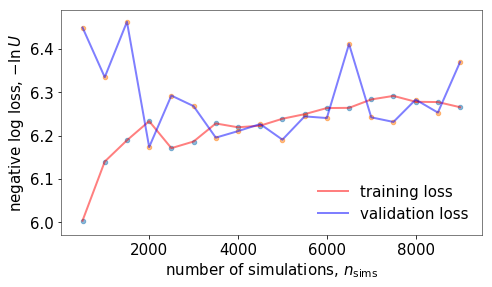

Population 18/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2961, Val_loss: 6.1971
Epoch 00001, Train_loss: 6.2970, Val_loss: 6.2051
Epoch 00002, Train_loss: 6.2925, Val_loss: 6.2015
Epoch 00003, Train_loss: 6.2940, Val_loss: 6.1998
Epoch 00004, Train_loss: 6.2920, Val_loss: 6.2023
Epoch 00005, Train_loss: 6.2912, Val_loss: 6.2021
Epoch 00006, Train_loss: 6.2918, Val_loss: 6.2023
Epoch 00007, Train_loss: 6.2901, Val_loss: 6.2043
Epoch 00008, Train_loss: 6.2915, Val_loss: 6.2033
Epoch 00009, Train_loss: 6.2892, Val_loss: 6.2047
Epoch 00010, Train_loss: 6.2901, Val_loss: 6.2064
Epoch 00011, Train_loss: 6.2892, Val_loss: 6.2052
Epoch 00012, Train_loss: 6.2891, Val_loss: 6.2058
Epoch 00013, Train_loss: 6.2924, Val_loss: 6.2067
Epoch 00014, Train_loss: 6.2884, Val_loss: 6.2075
Epoch 00015, Train_loss: 6.2887, Val_loss: 6.2095
Epoch 00016, Train_loss: 6.2891, Val_loss: 6.2077
Epoch 00017, Train_loss: 6.2906, Val_loss: 6.2086
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_18.pdf


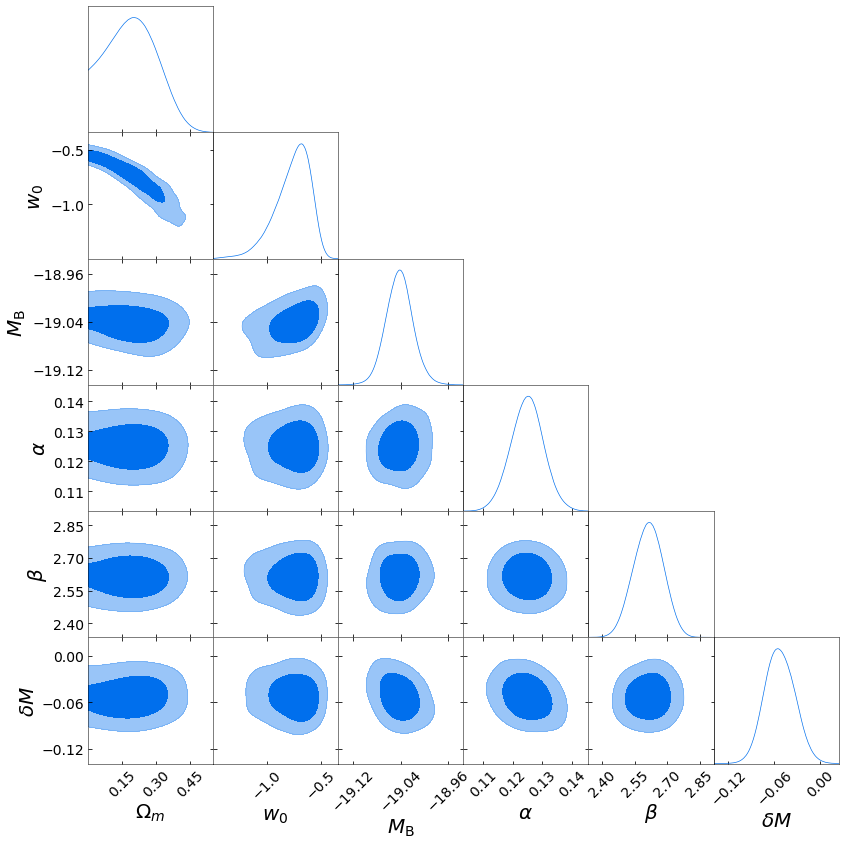

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


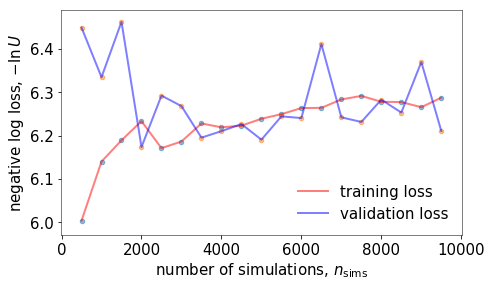

Population 19/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2905, Val_loss: 6.2551
Epoch 00001, Train_loss: 6.2894, Val_loss: 6.2594
Epoch 00002, Train_loss: 6.2887, Val_loss: 6.2606
Epoch 00003, Train_loss: 6.2907, Val_loss: 6.2582
Epoch 00004, Train_loss: 6.2916, Val_loss: 6.2595
Epoch 00005, Train_loss: 6.2879, Val_loss: 6.2649
Epoch 00006, Train_loss: 6.2885, Val_loss: 6.2669
Epoch 00007, Train_loss: 6.2889, Val_loss: 6.2690
Epoch 00008, Train_loss: 6.2869, Val_loss: 6.2644
Epoch 00009, Train_loss: 6.2906, Val_loss: 6.2628
Epoch 00010, Train_loss: 6.2936, Val_loss: 6.2644
Epoch 00011, Train_loss: 6.2871, Val_loss: 6.2662
Epoch 00012, Train_loss: 6.2858, Val_loss: 6.2650
Epoch 00013, Train_loss: 6.2856, Val_loss: 6.2687
Epoch 00014, Train_loss: 6.2850, Val_loss: 6.2685
Epoch 00015, Train_loss: 6.2860, Val_loss: 6.2703
Epoch 00016, Train_loss: 6.2857, Val_loss: 6.2704
Epoch 00017, Train_loss: 6.2851, Val_loss: 6.2682
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_19.pdf


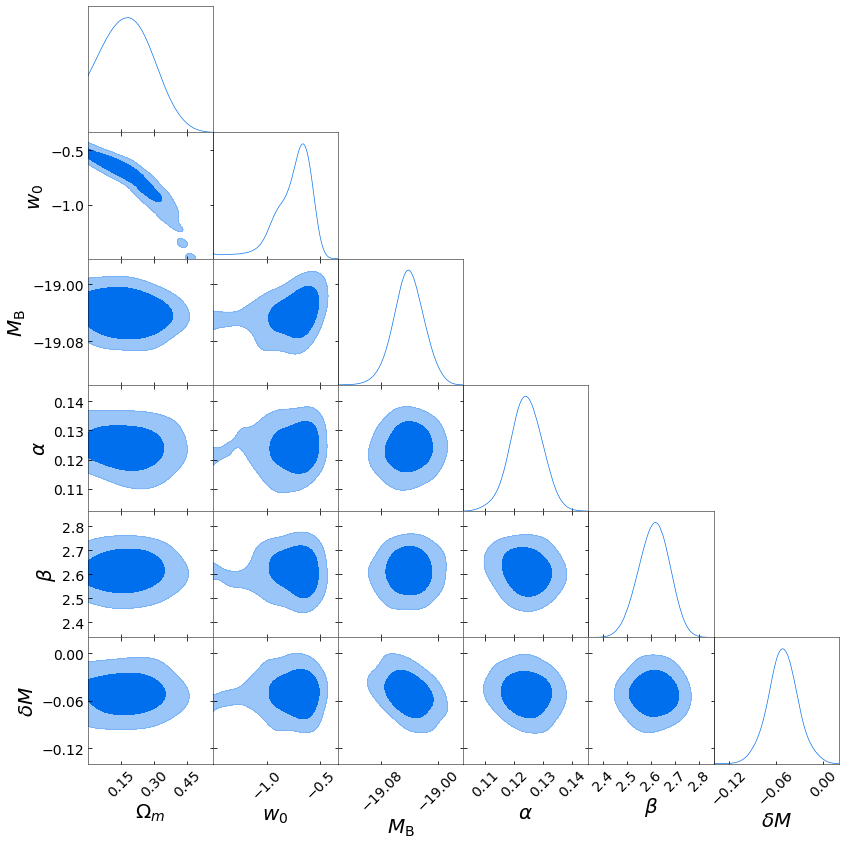

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


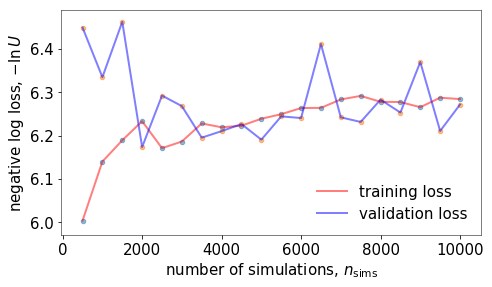

Population 20/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2919, Val_loss: 6.2875
Epoch 00001, Train_loss: 6.2916, Val_loss: 6.2931
Epoch 00002, Train_loss: 6.2904, Val_loss: 6.2949
Epoch 00003, Train_loss: 6.2901, Val_loss: 6.2924
Epoch 00004, Train_loss: 6.2899, Val_loss: 6.2950
Epoch 00005, Train_loss: 6.2895, Val_loss: 6.2945
Epoch 00006, Train_loss: 6.2892, Val_loss: 6.2993
Epoch 00007, Train_loss: 6.2898, Val_loss: 6.2942
Epoch 00008, Train_loss: 6.2903, Val_loss: 6.2958
Epoch 00009, Train_loss: 6.2890, Val_loss: 6.2953
Epoch 00010, Train_loss: 6.2880, Val_loss: 6.2980
Epoch 00011, Train_loss: 6.2888, Val_loss: 6.2964
Epoch 00012, Train_loss: 6.2889, Val_loss: 6.2960
Epoch 00013, Train_loss: 6.2878, Val_loss: 6.3004
Epoch 00014, Train_loss: 6.2880, Val_loss: 6.2991
Epoch 00015, Train_loss: 6.2886, Val_loss: 6.2994
Epoch 00016, Train_loss: 6.2885, Val_loss: 6.3057
Epoch 00017, Train_loss: 6.2877, Val_loss: 6.3003
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_20.pdf


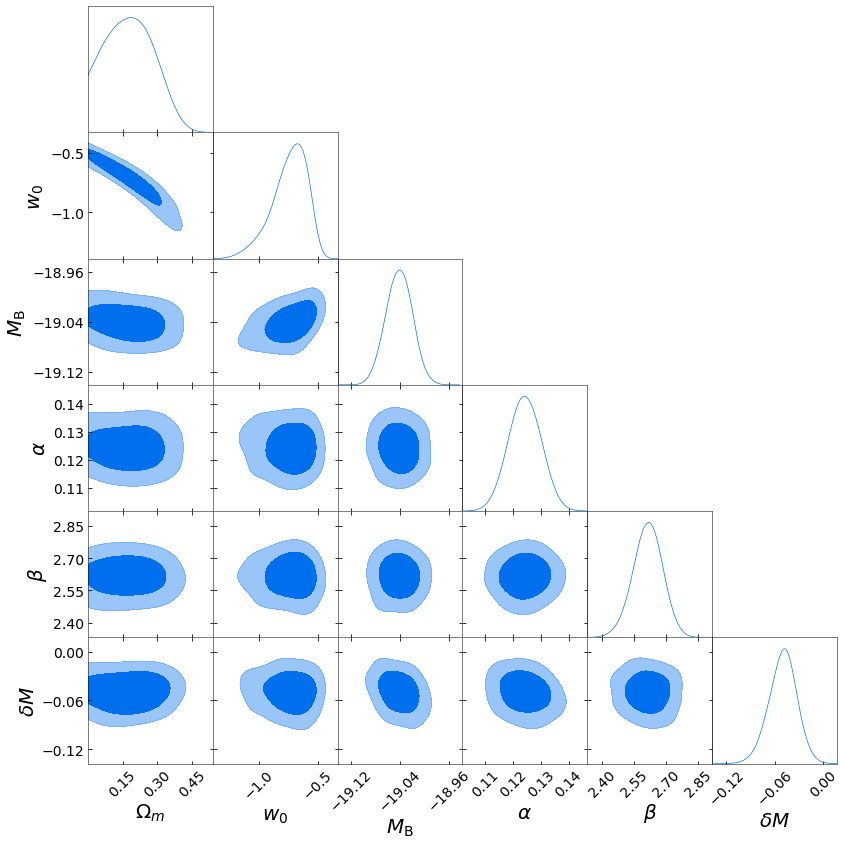

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


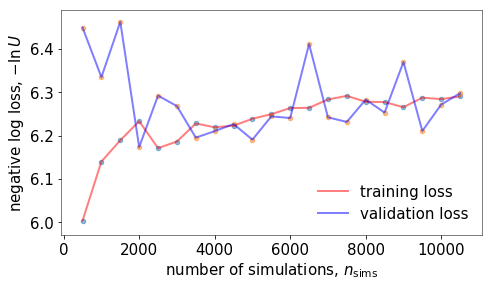

Population 21/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3002, Val_loss: 6.2231
Epoch 00001, Train_loss: 6.2996, Val_loss: 6.2280
Epoch 00002, Train_loss: 6.2988, Val_loss: 6.2260
Epoch 00003, Train_loss: 6.2983, Val_loss: 6.2265
Epoch 00004, Train_loss: 6.2993, Val_loss: 6.2283
Epoch 00005, Train_loss: 6.2985, Val_loss: 6.2287
Epoch 00006, Train_loss: 6.2980, Val_loss: 6.2300
Epoch 00007, Train_loss: 6.2979, Val_loss: 6.2331
Epoch 00008, Train_loss: 6.2967, Val_loss: 6.2286
Epoch 00009, Train_loss: 6.2963, Val_loss: 6.2291
Epoch 00010, Train_loss: 6.2982, Val_loss: 6.2328
Epoch 00011, Train_loss: 6.2982, Val_loss: 6.2317
Epoch 00012, Train_loss: 6.2963, Val_loss: 6.2292
Epoch 00013, Train_loss: 6.2955, Val_loss: 6.2292
Epoch 00014, Train_loss: 6.2950, Val_loss: 6.2324
Epoch 00015, Train_loss: 6.2951, Val_loss: 6.2296
Epoch 00016, Train_loss: 6.2970, Val_loss: 6.2354
Epoch 00017, Train_loss: 6.2952, Val_loss: 6.2314
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_21.pdf


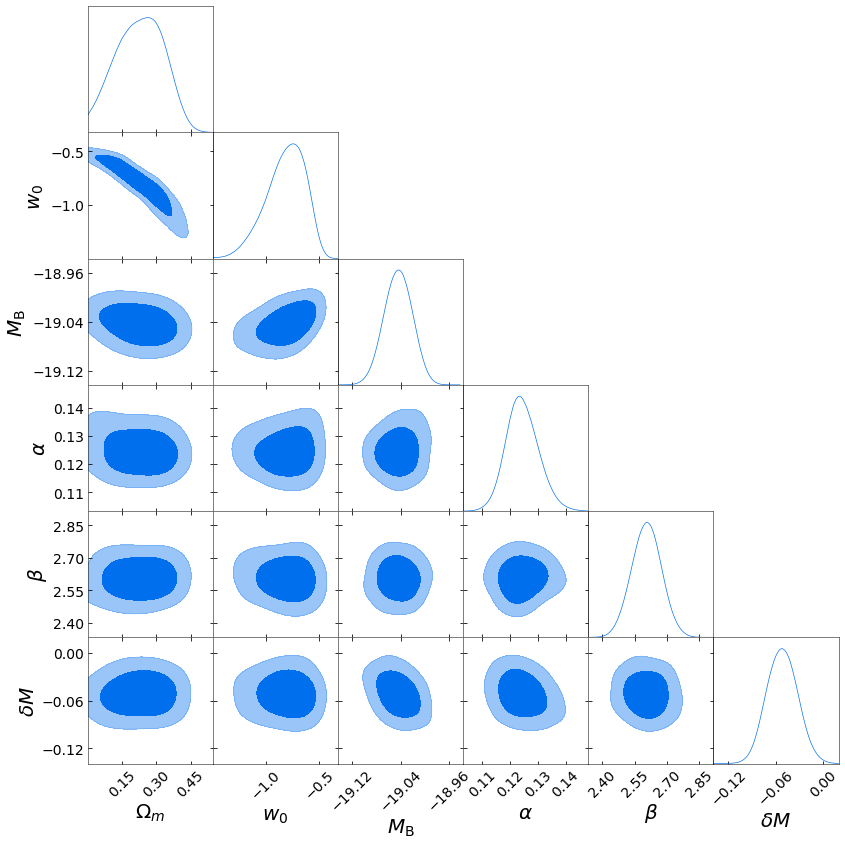

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


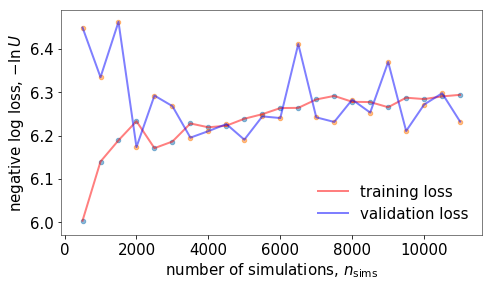

Population 22/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2986, Val_loss: 6.3270
Epoch 00001, Train_loss: 6.2970, Val_loss: 6.3272
Epoch 00002, Train_loss: 6.2968, Val_loss: 6.3298
Epoch 00003, Train_loss: 6.2991, Val_loss: 6.3317
Epoch 00004, Train_loss: 6.2957, Val_loss: 6.3310
Epoch 00005, Train_loss: 6.2952, Val_loss: 6.3310
Epoch 00006, Train_loss: 6.2948, Val_loss: 6.3314
Epoch 00007, Train_loss: 6.2960, Val_loss: 6.3323
Epoch 00008, Train_loss: 6.2983, Val_loss: 6.3347
Epoch 00009, Train_loss: 6.2952, Val_loss: 6.3337
Epoch 00010, Train_loss: 6.2936, Val_loss: 6.3336
Epoch 00011, Train_loss: 6.2934, Val_loss: 6.3344
Epoch 00012, Train_loss: 6.2935, Val_loss: 6.3332
Epoch 00013, Train_loss: 6.2927, Val_loss: 6.3314
Epoch 00014, Train_loss: 6.2929, Val_loss: 6.3368
Epoch 00015, Train_loss: 6.2921, Val_loss: 6.3336
Epoch 00016, Train_loss: 6.2929, Val_loss: 6.3336
Epoch 00017, Train_loss: 6.2966, Val_loss: 6.3383
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_22.pdf


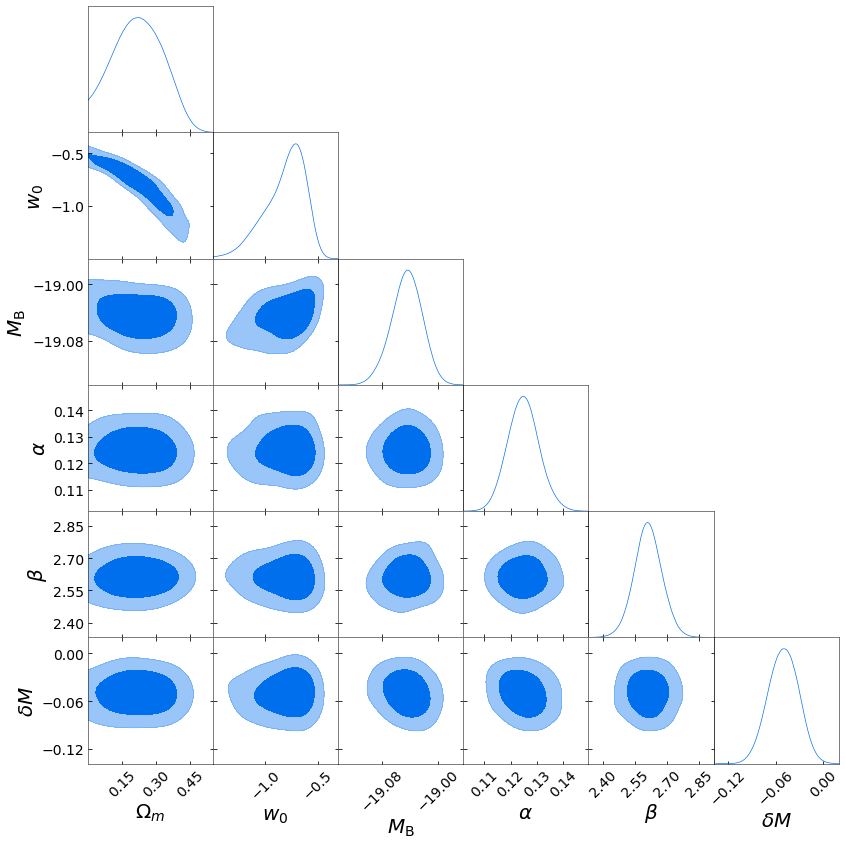

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


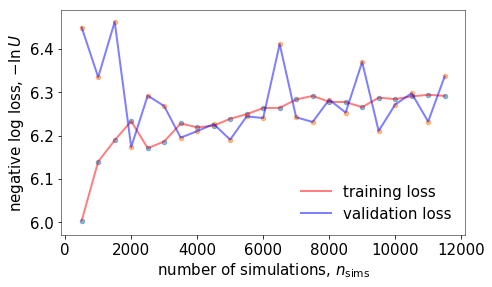

Population 23/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3002, Val_loss: 6.2808
Epoch 00001, Train_loss: 6.3007, Val_loss: 6.2874
Epoch 00002, Train_loss: 6.3002, Val_loss: 6.2886
Epoch 00003, Train_loss: 6.2993, Val_loss: 6.2873
Epoch 00004, Train_loss: 6.2978, Val_loss: 6.2895
Epoch 00005, Train_loss: 6.3000, Val_loss: 6.2926
Epoch 00006, Train_loss: 6.2980, Val_loss: 6.2905
Epoch 00007, Train_loss: 6.2986, Val_loss: 6.2941
Epoch 00008, Train_loss: 6.2962, Val_loss: 6.2886
Epoch 00009, Train_loss: 6.2969, Val_loss: 6.2900
Epoch 00010, Train_loss: 6.2963, Val_loss: 6.2920
Epoch 00011, Train_loss: 6.2956, Val_loss: 6.2922
Epoch 00012, Train_loss: 6.2958, Val_loss: 6.2914
Epoch 00013, Train_loss: 6.2950, Val_loss: 6.2944
Epoch 00014, Train_loss: 6.2946, Val_loss: 6.2898
Epoch 00015, Train_loss: 6.2944, Val_loss: 6.2926
Epoch 00016, Train_loss: 6.2948, Val_loss: 6.2922
Epoch 00017, Train_loss: 6.2943, Val_loss: 6.2927
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_23.pdf


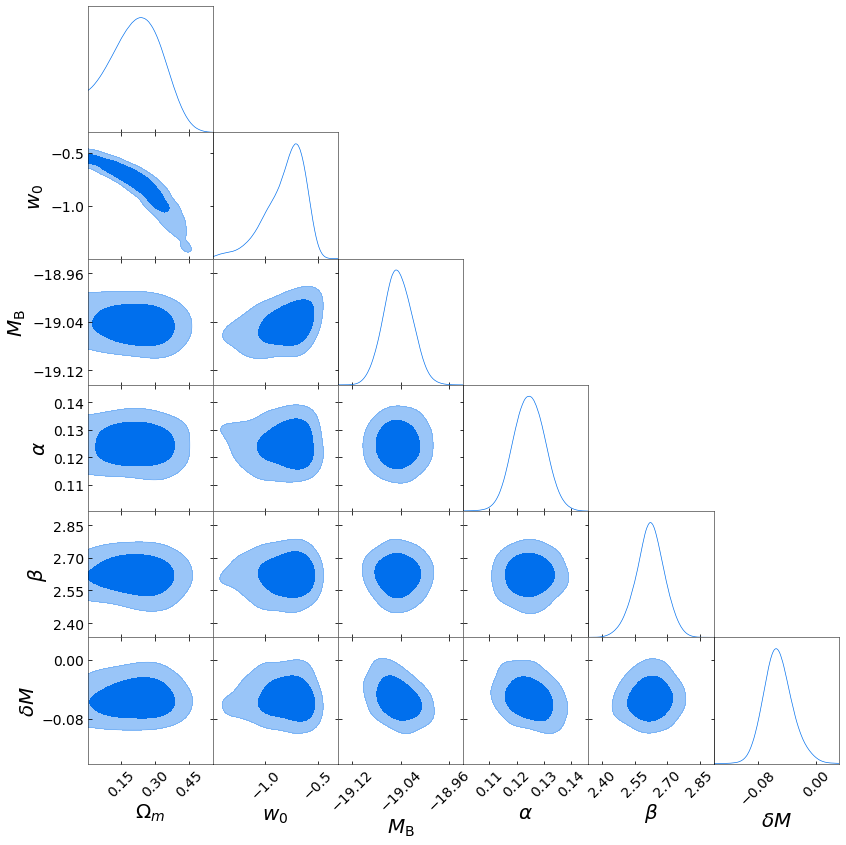

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


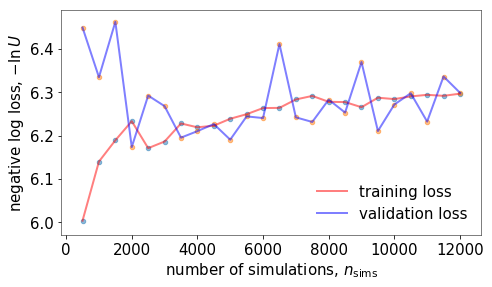

In [17]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
Delfi.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args)